# init

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import os, sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# print(os.getcwd())
os.chdir('/gpfs/data/healthcare-allocate/CLIF-MIMIC/code')
# print(os.getcwd())

proj_root = "/gpfs/data/healthcare-allocate/CLIF-MIMIC"
if proj_root not in sys.path:
    sys.path.append(proj_root)

# from code.custom_utils import *
import logging

## load tables

In [2]:
def load_mimic_table(module: {"icu", "hosp"}, table, file_type: {"csv", "parquet", "pq"} = "csv"):
    if file_type in ["pq", "parquet"]:
        return pd.read_parquet(f'../mimic-iv-2.2/{module}/{table}.parquet')
    elif file_type == "csv":
        return pd.read_csv(f'../mimic-iv-2.2/{module}/{table}.csv.gz')

In [3]:
patients = load_mimic_table("hosp", "patients") # gives gender
admissions = load_mimic_table("hosp", "admissions") # gives race and ethnicity

In [4]:
d_items = load_mimic_table("icu", "d_items", "csv")
chartevents = load_mimic_table("icu", "chartevents", "parquet")

In [5]:
procedureevents = load_mimic_table("icu", "procedureevents", "csv")
datetimeevents = load_mimic_table("icu", "datetimeevents", "csv")

In [6]:
inputevents = load_mimic_table("icu", "inputevents", "csv")
outputevents = load_mimic_table("icu", "outputevents", "csv")

In [7]:
# def resave_mimic_table_to_parquet(table: pd.DataFrame):
    # if not yet in memory, load it:
    # if not table:

In [8]:
# labevents = load_mimic_table("hosp", "labevents", "csv")
# labevents.to_parquet("../mimic-iv-2.2/hosp/labevents.parquet")
d_labitems = load_mimic_table("hosp", "d_labitems", "csv")
labevents = load_mimic_table("hosp", "labevents", "parquet")

poe = load_mimic_table("hosp", "poe", "csv")
poe_detail = load_mimic_table("hosp", "poe_detail", "csv")

transfers = load_mimic_table("hosp", "transfers", "csv")
icustays = load_mimic_table("icu", "icustays", "csv")

## load mappings

In [9]:
def load_mapping_csv(csv_name: str):
    return pd.read_csv(f"../mapping/mimic-to-clif-mappings - {csv_name}.csv")
# covert to a dict for df col renaming later

def construct_mapper_dict(mapping_df: pd.DataFrame, key_col: str, value_col: str, map_none_to_none = False):
    mapper_dict = dict(zip(mapping_df[key_col], mapping_df[value_col]))
    
    # Replace "NO MAPPING" with NA
    for key, value in mapper_dict.items():
        if value == "NO MAPPING":
            mapper_dict[key] = None
    
    # to enable a None -> None mapping
    if map_none_to_none:
        mapper_dict[None] = None
        
    return mapper_dict

In [98]:
# patient table
race_ethnicity_mapping = load_mapping_csv("race_ethnicity")
race_mapper_dict = construct_mapper_dict(race_ethnicity_mapping, "mimic_race", "race")
ethnicity_mapper_dict = construct_mapper_dict(race_ethnicity_mapping, "mimic_race", "ethnicity")

# hosp table
discharge_mapping = load_mapping_csv("discharge")
discharge_mapper_dict = construct_mapper_dict(
    discharge_mapping, "discharge_location", "disposition_category"
    )

# adt 
adt_mapping = load_mapping_csv("adt")
adt_mapper_dict = construct_mapper_dict(adt_mapping, "careunit", "location_category")

# vitals table
vitals_mapping = load_mapping_csv("vitals")
vital_name_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "label = vital_name")
vital_category_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "vital_category")

# resp support table
resp_mapping = load_mapping_csv("respiratory_support")
resp_device_mapping = load_mapping_csv("device_category")
resp_mode_mapping = load_mapping_csv("mode_category")

resp_mapper_dict = construct_mapper_dict(resp_mapping, "itemid", "variable")
resp_device_mapper_dict = construct_mapper_dict(resp_device_mapping, "device_name", "device_category")
resp_mode_mapper_dict = construct_mapper_dict(resp_mode_mapping, "mode_name", "mode_category")

In [11]:
resp_mode_mapper_dict

{'CPAP/PSV': 'Pressure Support/CPAP',
 'CMV/ASSIST/AutoFlow': 'Assist Control-Volume Control',
 'CMV/ASSIST': 'Assist Control-Volume Control',
 'MMV/PSV/AutoFlow': 'Other',
 'Standby': None,
 'PSV/SBT': 'Pressure Support/CPAP',
 'PRVC/AC': 'Pressure-Regulated Volume Control',
 'PCV+Assist': 'Pressure Control',
 'CPAP/PSV+ApnVol': 'Pressure-Regulated Volume Control',
 'SIMV/PSV/AutoFlow': 'SIMV',
 'MMV/PSV': 'Other',
 'CPAP': 'Pressure Support/CPAP',
 'APRV': 'Other',
 'CMV/AutoFlow': 'Assist Control-Volume Control',
 'CPAP/PPS': 'Pressure Support/CPAP',
 'CPAP/PSV+ApnPres': 'Pressure Support/CPAP',
 'VOL/AC': 'Assist Control-Volume Control',
 'PCV+': 'Pressure Control',
 'CMV': 'Assist Control-Volume Control',
 'PCV+/PSV': 'Pressure Control',
 'PRES/AC': 'Assist Control-Volume Control',
 'SIMV/PSV': 'SIMV',
 'APV (cmv)': 'Pressure-Regulated Volume Control',
 'SPONT': 'Pressure Support/CPAP',
 'MMV': 'Other',
 'Apnea Ventilation': 'Blow by',
 'APRV/Biphasic+ApnVol': 'Other',
 'MMV/AutoF

# utils

In [12]:
logging.basicConfig(
    level = logging.INFO,
    format = '%(asctime)s:%(levelname)s:%(message)s',
    handlers = [logging.FileHandler("mimic-to-clif.log"),
              logging.StreamHandler()])

## `CacheInfo` class

In [13]:
class CacheInfo:
    """
    CacheInfo object used to represent the current status of `lru_cache`
    """
    def __init__(self, max_size):
        self.max_size = max_size
        self.misses = 0
        self.hits = 0
        self.cur_size = 0
        # NOTE: you may add to this if you want, but do not modify the lines above
        # create an attribute in the CacheInfo class to store the cache dict
        self.cache_dict = {}
    
    def __repr__(self):
        return f"CacheInfo(hits={self.hits}, misses={self.misses}, max_size={self.max_size}, cur_size={self.cur_size})"

# first layer: a decorator factory
def lru_cache(max_size = 128):
    '''
    This function is a decorator factory that returns a decorator with a user-specified
    maximum size of the cache 

    Input:
        - max_size: the maximum size of the cache
    
    Output: 
        - a decorator
    '''
    # second layer: the decorator
    def decorator(func):
        '''
        This function is a decorator that takes in an original function and
        return a new, decorated function.

        Input: an original function

        Output: a new function
        '''
        # initialize an instance of the CacheInfo class
        cache_info = CacheInfo(max_size = max_size)
        def key_generator(*args, **kwargs):
            '''
            This helper function creates a unique key given every different 
            combination of positional and key-word arguments

            Input: 
                - *args: any position arguments
                - **kwargs: any key word arguments

            Output: 
                - a tuple that stores all the arguments and their data type
            '''
            # generates a tuple that stores the data type of each position arg
            args_type = tuple(map(lambda x: type(x), args))
            # kwargs is a dict, so we use items() to turn it into a seq of
            # key-value tuples, and add the data type of the key word arg
            # to the tuple, then use frozenset() to make it immutable and 
            # thus hashable
            kwargs_and_type = frozenset(
                       map(lambda tup: (tup, type(tup[1])), 
                           kwargs.items()))
            return (args, args_type, kwargs_and_type)
        def new_func(*args, **kwargs):
            '''
            This is the new function that replaces the original function.

            Input:
                - *args, **kwargs: any position and key word arguments

            Output:
                - the result of the new function
            '''
            key = key_generator(*args, **kwargs)        
            # if the key is already in the cache dict, i.e. the same args have
            # been provided before, there should be "memory" in the cache
            # we got a hit
            if key in cache_info.cache_dict:
                cache_info.hits += 1 
                # temporarily store the cache result first before we remove the key
                cached_result = cache_info.cache_dict[key]
                # remove the key
                cache_info.cache_dict.pop(key)
                # insert the same key to the tail of the dict
                cache_info.cache_dict[key] = cached_result
                return cached_result
            # when we have a new arg combination that is not seen before 
            # -- we have a "miss":
            else:
                cache_info.misses += 1  
                # add the output of the function to the dict
                cache_info.cache_dict[key] = func(*args, **kwargs)  
                # update cache size (length of the dict) 
                cache_info.cur_size = len(cache_info.cache_dict) 
                # if the cache exceeds the maximum size, remove the least recently used item
                if len(cache_info.cache_dict) > max_size:
                    # first covert the dict to a list so we can track the order
                    cache_list = list(cache_info.cache_dict.items())
                    # remove the first element in the list, which is the least 
                    # recently used item
                    cache_list.pop(0)
                    # convert the list back to a dict and update
                    cache_info.cache_dict = dict(cache_list)
                    # update the cache size again, which should = max_size
                    cache_info.cur_size = len(cache_info.cache_dict)  
                return cache_info.cache_dict[key]
        # update the attribute of the now-decorated new func
        new_func.cache_info = cache_info
        return new_func     
    return decorator

## helper funcs

In [14]:
def convert_and_sort_datetime(df: pd.DataFrame, event_type: {"ce", "pe", "other"}, time_col_name = "time"):
    # if procedure event
    if event_type == "pe":
        df["starttime"] = pd.to_datetime(df["starttime"])
        df["endtime"] = pd.to_datetime(df["endtime"])
        df = df.sort_values(["hadm_id", "starttime", "endtime", "storetime"]).reset_index(drop = True).reset_index()
    elif event_type == "ce":
        df["charttime"] = pd.to_datetime(df['charttime'])
        df = df.sort_values(["hadm_id", "charttime", "storetime"]).reset_index(drop = True).reset_index()
    elif event_type == "other":
        df["time"] = pd.to_datetime(df['time'])
        df = df.sort_values(["hadm_id", "time"])
    return df

In [15]:
def save_to_rclif(df: pd.DataFrame, table_name, file_format = "pq"):
    if file_format in ["pq", "parquet"]:
        df.to_parquet(f'../rclif/clif_{table_name}.parquet')

def read_from_rclif(table_name, file_format = "pq"):
    if file_format in ["pq", "parquet"]:
        return pd.read_parquet(f'../rclif/clif_{table_name}.parquet')

In [106]:
# FIXME: delete "ALREDAY MAPPED" at some pt
EXCLUDED_LABELS_DEFAULT = ["NO MAPPING", "UNSURE", "MAPPED ELSEWHERE", "SPECIAL CASE", "ALREADY MAPPED"] 

# find all the relevant item ids for a table
def get_relevant_item_ids(mapping_df: pd.DataFrame, decision_col: str, 
                          excluded_labels: list = EXCLUDED_LABELS_DEFAULT,
                          excluded_item_ids: list = None
                          ):
    '''
    - decision_col: the col on which to apply the excluded_labels
    - excluded_item_ids: additional item ids to exclude
    '''
    if not excluded_item_ids:
        excluded_item_ids = []
    
    return mapping_df.loc[
        (~mapping_df[decision_col].isin(excluded_labels)) & 
        (~mapping_df["itemid"].isin(excluded_item_ids))
        , "itemid"
        ].unique()
    
def rename_and_reorder_cols(df, rename_mapper_dict: dict, new_col_order: list) -> pd.DataFrame:
    baseline_rename_mapper = {
        "subject_id": "patient_id", "hadm_id": "hospitalization_id",
    }
    
    return (
        df.rename(columns = baseline_rename_mapper | rename_mapper_dict)
        .reindex(columns = new_col_order)
        )

def find_duplicates(df, cols: list[str] = ["hadm_id", "time", "itemid"]):
    '''
    Check whether there are duplicates -- more than one populated value -- for what is supposed to be 
    unique combination of columns. That is, for the same measured variable (e.g. vital_category) at
    the same time during the same encounter, there should be only one corresponding value.
    '''
    return df[df.duplicated(subset = cols, keep = False)]

def check_duplicates(df: pd.DataFrame, additional_cols: list):
    '''
    Check whether there are duplicates -- more than one populated value -- for what is supposed to be 
    unique combination of columns. That is, for the same measured variable (e.g. vital_category) at
    the same time during the same hospitalization, there should be only one corresponding value.
    '''
    cols_to_check = ["hospitalization_id", "recorded_dttm"].extend(additional_cols)
    return df[df.duplicated(subset = cols_to_check, keep = False)]

In [17]:
@lru_cache()
def item_id_to_feature_value(item_id: int, col: str = "label", df = d_items):
    '''
    Find the corresponding feature value of an item by id.
    i.e. find the label, or linksto, of item id 226732.
    '''
    row = df.loc[df["itemid"] == item_id, :]
    label = row["label"].values[0]
    if col == "label":
        logging.info(f"the {col} for item {item_id} is {label}")
        return label
    else:
        feature_value = row[col].values[0]
        logging.info(f"the {col} for item {item_id} ({label}) is {feature_value}")
        return feature_value

@lru_cache()
def item_id_to_label(item_id: int) -> str:
    '''
    Helper function that returns the "label" string of an item given its item_id. 
    '''
    return item_id_to_feature_value(item_id)

def item_id_to_events_df(item_id: int, simplify: bool = True) -> pd.DataFrame:
    '''
    Return in a pandas df all the events associated with an item id.
    - simplify: whether to return the original df (False), or a simplified one 
    with some columns (particulary timestamps) renamed to support integration 
    between different events df.  # FIXME - might rename this arg
    '''
    # find whether it is chartevents, or procedure events, etc.
    linksto_table_name = item_id_to_feature_value(item_id, col = "linksto")
    # turn string into a dj object
    linksto_df: pd.DataFrame = globals()[linksto_table_name]
    events_df = linksto_df.loc[linksto_df["itemid"] == item_id, :]
    # if does not simplify, return the original column
    if not simplify:
        return events_df
    # else, if simplified:
    elif linksto_table_name == "procedureevents": # FIXME: trach is complex and need additional attention
        events_df_simplified = events_df.loc[
            :, ['subject_id', 'hadm_id', 'stay_id', 'endtime', 'itemid', 'value', 'valueuom']
        ].rename(columns = {"endtime": "time"})
        return events_df_simplified
    elif linksto_table_name == "chartevents":
        events_df_simplified = events_df.loc[
            :, ['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid', 'value', 'valueuom']
        ].rename(columns = {"charttime": "time"})
        return events_df_simplified
        
    # FIXME: likely an issue if data struct of different events table are different 

def item_ids_list_to_events_df(item_ids: list):
    df_list = [item_id_to_events_df(item_id, simplify = True) for item_id in item_ids]
    df_merged = pd.concat(df_list) #.head().assign(
        ## linksto = lambda df: df["itemid"].apply(lambda item_id: item_id_to_feature_value(item_id, col = "linksto"))
    # )
    return df_merged 
    # FIXME: automatically add the label and linksto table source columns -- create cache?

## `ItemFinder` class

In [18]:
class ItemFinder():
    def __init__(self, kw = None, items_df = d_items, 
                 col: str = "label", case_sensitive: bool = False, for_labs: bool = False):
        '''
        Look up an item by keyword from the `d_items` table of the `icu` module.
        - case: whether the search is case sensitive
        '''
        self.kw = kw 
        self.df = items_df
        self.col = "abbreviation" if col == "abbr" else col
        self.for_labs = for_labs

        # df of items that match the key words -- a raw output
        self.items_select_df: pd.DataFrame = items_df[
            items_df[self.col].str.contains(kw, case = case_sensitive, na = False)
        ]
        
        # first check whether there is any return in the raw output
        if len(self.items_select_df) == 0:
            raise Exception(f"No matching result found in column {col} with case sensitive being {case_sensitive} ")
        
        # ... only proceed when the return is not of zero length
        # and enhance the simple raw output with counts and value instances
        else:
            logging.info(f"{len(self.items_select_df)} matching item(s) found.")
            # list of ids for items that match the key words
            self.items_select_ids = self.items_select_df["itemid"].values
            # a np array of non-duplicated events table names, e.g. ["chartevents", "procedureevents"]
            self.linksto_table_names = self.items_select_df["linksto"].unique()
            self.item_freq = self.generate_item_freq()
            logging.info(f"type is {type(self.item_freq)}")
            self.candidate_table = self.make_candidate_table()

    def generate_item_freq(self):
        '''
        Iterative over each events table, find the items freq therein, and combine into one df.
        # FIXME - should maybe make this map style without loop
        '''
        freq_df_ls = [] # a list of df's
        for table_name in self.linksto_table_names:
            # fetch the object by name str, i.e. chartevents, procedureevents, etc.
            events_df: pd.DataFrame = globals()[table_name]
            # filter for all the selected events in that events table
            events_select_df = events_df.loc[
                events_df["itemid"].isin(self.items_select_ids), :
            ]
            # a df of item freq for one event type  
            item_freq = events_select_df.value_counts("itemid")
            item_freq.name = "count"

            # check if the df is empty -- there shouldn't be an empty one FIXME
            # if not item_freq_df.empty:
            freq_df_ls.append(item_freq)
        
        return pd.concat(freq_df_ls)

    def make_candidate_table(self):
        '''
        merge item freq and values instances to the raw output to generate the enhanced table of the 
        candidate items.
        '''
        cand_table = (
            self.items_select_df
            .loc[:, ["itemid", "label", "abbreviation", "linksto", "category", "unitname", "param_type"]]
            # FIXME
            .join(self.item_freq, on = "itemid", validate = "1:1")
            .sort_values(by = "count", ascending = False) 
            .assign(
                value_instances = lambda df: df["itemid"].apply(item_id_to_value_instances)
            )
        )
        if self.for_labs:
            return cand_table.reindex(
                columns = ["itemid", "label", "abbreviation", "linksto", "category", "count", "value_instances", "unitname"]
                )
        else:
            return cand_table

@lru_cache()
def item_id_to_value_instances(item_id: int):
    '''
    Wrapper
    '''
    label = item_id_to_feature_value(item_id, "label")

    param_type = item_id_to_feature_value(item_id, "param_type")
    
    if param_type == "Numeric":
        val_instances = item_id_to_value_instances_numeric(item_id)
    elif param_type == "Text":
        val_instances = item_id_to_value_instances_categorical(item_id).to_dict()
    else:
        return param_type
    print(f"item label: {label}; value instances: {str(val_instances)}")
    return str(val_instances)

def item_id_to_value_instances_categorical(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Return all the unique categories
    '''
    assoc_events = events.loc[events["itemid"] == item_id, :]
    categories: pd.Series = assoc_events.value_counts("value") 
    return categories
    
def item_id_to_value_instances_numeric(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Find max, min, mean of a continuous, or numeric, item.
    '''
    valuenum_col = events.loc[events["itemid"] == item_id, :]["valuenum"]
    val_max, val_min, val_mean = valuenum_col.max(), valuenum_col.min(), round(valuenum_col.mean(), 2)
    return f"Max: {val_max}, Min: {val_min}, Mean: {val_mean}"

In [19]:
ItemFinder("weight").candidate_table

2024-10-07 21:10:15,174:INFO:9 matching item(s) found.
2024-10-07 21:10:18,121:INFO:type is <class 'pandas.core.series.Series'>
2024-10-07 21:10:18,226:INFO:the label for item 224639 is Daily Weight
2024-10-07 21:10:18,235:INFO:the param_type for item 224639 (Daily Weight) is Numeric
2024-10-07 21:10:18,600:INFO:the label for item 226531 is Admission Weight (lbs.)
2024-10-07 21:10:18,603:INFO:the param_type for item 226531 (Admission Weight (lbs.)) is Numeric


item label: Daily Weight; value instances: Max: 1103030.0, Min: -176.0, Mean: 94.83


2024-10-07 21:10:18,968:INFO:the label for item 225124 is Unintentional weight loss >10 lbs.
2024-10-07 21:10:18,972:INFO:the param_type for item 225124 (Unintentional weight loss >10 lbs.) is Checkbox
2024-10-07 21:10:18,975:INFO:the label for item 226512 is Admission Weight (Kg)
2024-10-07 21:10:18,978:INFO:the param_type for item 226512 (Admission Weight (Kg)) is Numeric


item label: Admission Weight (lbs.); value instances: Max: 44000.0, Min: 0.0, Mean: 180.73


2024-10-07 21:10:19,335:INFO:the label for item 226846 is Feeding Weight
2024-10-07 21:10:19,338:INFO:the param_type for item 226846 (Feeding Weight) is Numeric


item label: Admission Weight (Kg); value instances: Max: 5864.0, Min: 1.0, Mean: 81.13


2024-10-07 21:10:19,654:INFO:the label for item 227854 is Weight Bearing Status
2024-10-07 21:10:19,658:INFO:the param_type for item 227854 (Weight Bearing Status) is Text


item label: Feeding Weight; value instances: Max: 5104.0, Min: 0.0, Mean: 70.68


2024-10-07 21:10:19,991:INFO:the label for item 226740 is APACHE II Diagnosistic weight factors - Medical
2024-10-07 21:10:19,995:INFO:the param_type for item 226740 (APACHE II Diagnosistic weight factors - Medical) is Text


item label: Weight Bearing Status; value instances: {'NWB RUE': 3, 'WBAT RLE': 3, 'WBAT LLE': 2, 'NWB LUE': 2, 'FWB RLE': 1, 'FWB LLE': 1, 'FWB LUE': 1, 'FWB RUE': 1, 'NWB LLE': 1, 'WBAT LUE': 1, 'WBAT RUE': 1}


2024-10-07 21:10:20,273:INFO:the label for item 226741 is APACHE II Diagnosistic weight factors - Surgical emergency
2024-10-07 21:10:20,276:INFO:the param_type for item 226741 (APACHE II Diagnosistic weight factors - Surgical emergency) is Text


item label: APACHE II Diagnosistic weight factors - Medical; value instances: {}


2024-10-07 21:10:20,549:INFO:the label for item 226742 is APACHE II Diagnosistic weight factors - Surgical
2024-10-07 21:10:20,552:INFO:the param_type for item 226742 (APACHE II Diagnosistic weight factors - Surgical) is Text


item label: APACHE II Diagnosistic weight factors - Surgical emergency; value instances: {}
item label: APACHE II Diagnosistic weight factors - Surgical; value instances: {}


itemid                                              label  \
764   224639                                       Daily Weight   
1866  226531                            Admission Weight (lbs.)   
1097  225124                 Unintentional weight loss >10 lbs.   
1856  226512                              Admission Weight (Kg)   
1993  226846                                     Feeding Weight   
2484  227854                              Weight Bearing Status   
1950  226740    APACHE II Diagnosistic weight factors - Medical   
1951  226741  APACHE II Diagnosistic weight factors - Surgic...   
1952  226742   APACHE II Diagnosistic weight factors - Surgical   

                                           abbreviation      linksto  \
764                                        Daily Weight  chartevents   
1866                            Admission Weight (lbs.)  chartevents   
1097                 Unintentional weight loss >10 lbs.  chartevents   
1856                              Admission Weight (Kg)  chartevents   
1993                                     Feeding Weight  chartevents   
2484                              Weight Bearing Status  chartevents   
1950               Diagnostic weight category - Medical  chartevents   
1951  Diagnosistic weight categories - Surgical emer...  chartevents   
1952          Diagnosistic weight categories - Surgical  chartevents   

                category unitname param_type     count  \
764              General       kg    Numeric  202491.0   
1866             General      NaN    Numeric  119251.0   
1097    Adm History/FHPA      NaN   Checkbox   73806.0   
1856             General       kg    Numeric   67826.0   
1993             General       kg    Numeric    7223.0   
2484            OT Notes      NaN       Text      17.0   
1950  Scores - APACHE II      NaN       Text       NaN   
1951  Scores - APACHE II      NaN       Text       NaN   
1952  Scores - APACHE II      NaN       Text       NaN   

                                        value_instances  
764            Max: 1103030.0, Min: -176.0, Mean: 94.83  
1866               Max: 44000.0, Min: 0.0, Mean: 180.73  
1097                                           Checkbox  
1856                 Max: 5864.0, Min: 1.0, Mean: 81.13  
1993                 Max: 5104.0, Min: 0.0, Mean: 70.68  
2484  {'NWB RUE': 3, 'WBAT RLE': 3, 'WBAT LLE': 2, '...  
1950                                                 {}  
1951                                                 {}  
1952                                                 {}

# `patient_encounters` table

In [75]:
# Since each unique hospital visit for a patient is assigned a unique hadm_id, the admissions table can be considered as a definition table for hadm_id.
patient_encounters = admissions[["subject_id", "hadm_id"]]
patient_encounters.columns = ["patient_id", "hospitalization_id"]
# check for duplicates
patient_encounters.duplicated().sum()

0

In [124]:
patient_encounters["patient_id"] = patient_encounters["patient_id"].astype(str)
patient_encounters["hospitalization_id"] = patient_encounters["hospitalization_id"].astype(str)

/tmp/ipykernel_1055/2358207730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_encounters["patient_id"] = patient_encounters["patient_id"].astype(str)
/tmp/ipykernel_1055/2358207730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_encounters["encounter_id"] = patient_encounters["encounter_id"].astype(str)


In [125]:
patient_encounters.dtypes

patient_id      object
encounter_id    object
dtype: object

In [126]:
patient_encounters.to_parquet('../rclif/patient_encounters.parquet')

# `patient` table

death from admissions table

## utils

In [49]:
patients.head()

subject_id gender  anchor_age  anchor_year anchor_year_group         dod
0    10000032      F          52         2180       2014 - 2016  2180-09-09
1    10000048      F          23         2126       2008 - 2010         NaN
2    10000068      F          19         2160       2008 - 2010         NaN
3    10000084      M          72         2160       2017 - 2019  2161-02-13
4    10000102      F          27         2136       2008 - 2010         NaN

In [50]:
patients[patients.duplicated(["subject_id"])]

Empty DataFrame
Columns: [subject_id, gender, anchor_age, anchor_year, anchor_year_group, dod]
Index: []

## EDA

In [20]:
# multiple race for one patient
race_counts = admissions.groupby('subject_id')['race'].nunique()
multi_race_indices = race_counts[race_counts > 1].index
multi_race_encounters = admissions[
    admissions['subject_id'].isin(multi_race_indices)
    ][["subject_id", "hadm_id", "race", "admittime", "admission_type", "admission_location"]]
multi_race_encounters

subject_id   hadm_id                    race            admittime  \
87        10002013  21763296                   WHITE  2165-11-23 08:19:00   
88        10002013  21975601                   WHITE  2159-12-14 23:55:00   
89        10002013  23581541                   OTHER  2160-05-18 07:45:00   
90        10002013  23745275                   WHITE  2157-10-31 12:54:00   
91        10002013  24760295                   OTHER  2160-07-10 19:33:00   
...            ...       ...                     ...                  ...   
431136    19997911  27144120  WHITE - OTHER EUROPEAN  2196-09-16 23:53:00   
431137    19997911  27402845                   WHITE  2193-09-02 10:44:00   
431190    19999287  20175828  BLACK/AFRICAN AMERICAN  2197-08-03 20:58:00   
431191    19999287  22997012  BLACK/AFRICAN AMERICAN  2197-07-26 03:29:00   
431192    19999287  25875727                   WHITE  2191-12-29 07:15:00   

                     admission_type  admission_location  
87                     DIRECT EMER.     CLINIC REFERRAL  
88                         EW EMER.      EMERGENCY ROOM  
89      SURGICAL SAME DAY ADMISSION  PHYSICIAN REFERRAL  
90           AMBULATORY OBSERVATION      PROCEDURE SITE  
91                         EW EMER.      EMERGENCY ROOM  
...                             ...                 ...  
431136            OBSERVATION ADMIT      EMERGENCY ROOM  
431137               EU OBSERVATION      EMERGENCY ROOM  
431190                     EW EMER.      EMERGENCY ROOM  
431191                     EW EMER.      EMERGENCY ROOM  
431192  SURGICAL SAME DAY ADMISSION  PHYSICIAN REFERRAL  

[47711 rows x 6 columns]

In [6]:
# but only one race per encounter: 
race_counts = admissions.groupby('hadm_id')['race'].nunique()
race_counts[race_counts > 1].index

Index([], dtype='int64', name='hadm_id')

In [9]:
# check for South Americans
south_american_subject_ids = admissions.loc[admissions["race"] == "SOUTH AMERICAN", "subject_id"].unique()
sa_race_counts = (
    admissions[admissions["subject_id"].isin(south_american_subject_ids)]
    .groupby('subject_id')['race'].nunique()
)
multi_race_indices = sa_race_counts[sa_race_counts > 1].index
multi_race_encounters = admissions[
    admissions['subject_id'].isin(multi_race_indices)
    ][["subject_id", "hadm_id", "race", "admittime", "admission_type", "admission_location"]]
multi_race_encounters

subject_id   hadm_id                          race  \
6419      10154376  24770530                SOUTH AMERICAN   
6420      10154376  26894987                       UNKNOWN   
6421      10154376  27022201            HISPANIC OR LATINO   
6422      10154376  27499017            HISPANIC OR LATINO   
6423      10154376  27745331                       UNKNOWN   
...            ...       ...                           ...   
429330    19954807  21606941                SOUTH AMERICAN   
429331    19954807  22024006  HISPANIC/LATINO - SALVADORAN   
429332    19954807  23679253  HISPANIC/LATINO - SALVADORAN   
429333    19954807  27508241  HISPANIC/LATINO - SALVADORAN   
429334    19954807  27989967  HISPANIC/LATINO - SALVADORAN   

                  admittime     admission_type  admission_location  
6419    2178-09-15 02:10:00     EU OBSERVATION      EMERGENCY ROOM  
6420    2177-12-02 13:41:00             URGENT  PHYSICIAN REFERRAL  
6421    2174-07-28 18:23:00           EW EMER.      EMERGENCY ROOM  
6422    2174-08-09 22:34:00           EW EMER.      EMERGENCY ROOM  
6423    2176-09-11 01:00:00             URGENT  PHYSICIAN REFERRAL  
...                     ...                ...                 ...  
429330  2189-03-18 20:07:00           EW EMER.                PACU  
429331  2193-09-22 20:19:00  OBSERVATION ADMIT      EMERGENCY ROOM  
429332  2189-12-12 21:35:00     EU OBSERVATION      EMERGENCY ROOM  
429333  2191-11-10 23:10:00     EU OBSERVATION      EMERGENCY ROOM  
429334  2193-01-31 22:22:00     EU OBSERVATION      EMERGENCY ROOM  

[342 rows x 6 columns]

In [18]:
(sa_race_counts == 1).sum()

212

In [16]:
len(multi_race_encounters["subject_id"].unique())

56

## ETL

### gender / sex

In [97]:
# fetch sex (intended in CLIF) / gender (available in MIMIC)
patient_demo_sex = patients[["subject_id", "gender"]] 
patient_demo_sex.columns = ["patient_id", "gender"]
patient_demo_sex["sex"] = patient_demo_sex["gender"].map(lambda x: "Female" if x == "F" else "Male")
patient_demo_sex.head()

/tmp/ipykernel_1055/54858974.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_demo_sex["sex"] = patient_demo_sex["gender"].map(lambda x: "Female" if x == "F" else "Male")


patient_id gender     sex
0    10000032      F  Female
1    10000048      F  Female
2    10000068      F  Female
3    10000084      M    Male
4    10000102      F  Female

In [89]:
# check for NA
patients["gender"].isna().sum()

0

### race and ethnicity

In [92]:
# race and ethnicity
patient_demo_race_ethn = admissions[["hadm_id", "race"]]
patient_demo_race_ethn.columns = ["hospitalization_id", "mimic_race"]
patient_demo_race_ethn["race"] = patient_demo_race_ethn["mimic_race"].map(race_mapper_dict)
patient_demo_race_ethn["ethnicity"] = patient_demo_race_ethn["mimic_race"].map(ethnicity_mapper_dict)
patient_demo_race_ethn.head()

/tmp/ipykernel_1055/1549762778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_demo_race_ethn["race"] = patient_demo_race_ethn["mimic_race"].map(race_mapper_dict)
/tmp/ipykernel_1055/1549762778.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_demo_race_ethn["ethnicity"] = patient_demo_race_ethn["mimic_race"].map(ethnicity_mapper_dict)


encounter_id mimic_race   race     ethnicity
0      22595853      WHITE  White  Non-Hispanic
1      22841357      WHITE  White  Non-Hispanic
2      25742920      WHITE  White  Non-Hispanic
3      29079034      WHITE  White  Non-Hispanic
4      25022803      WHITE  White  Non-Hispanic

### merge and save

In [116]:
patient_demographics = pd.merge(
    patient_encounters, patient_demo_sex, on = "patient_id", how = "inner"
)

patient_demographics = pd.merge(
    patient_demographics, patient_demo_race_ethn, on = "hospitalization_id", how = "outer", indicator = True)

patient_demographics.head()

patient_id  encounter_id gender     sex mimic_race   race     ethnicity  \
0    10000032      22595853      F  Female      WHITE  White  Non-Hispanic   
1    10000032      22841357      F  Female      WHITE  White  Non-Hispanic   
2    10000032      25742920      F  Female      WHITE  White  Non-Hispanic   
3    10000032      29079034      F  Female      WHITE  White  Non-Hispanic   
4    10000068      25022803      F  Female      WHITE  White  Non-Hispanic   

  _merge  
0   both  
1   both  
2   both  
3   both  
4   both

In [117]:
patient_demographics.value_counts("_merge")

_merge
both          431231
left_only          0
right_only         0
dtype: int64

In [118]:
patient_demographics_final = patient_demographics[["hospitalization_id", "race", "ethnicity", "sex"]]
patient_demographics_final.head()

encounter_id   race     ethnicity     sex
0      22595853  White  Non-Hispanic  Female
1      22841357  White  Non-Hispanic  Female
2      25742920  White  Non-Hispanic  Female
3      29079034  White  Non-Hispanic  Female
4      25022803  White  Non-Hispanic  Female

In [119]:
patient_demographics_final.dtypes

encounter_id     int64
race            object
ethnicity       object
sex             object
dtype: object

In [120]:
patient_demographics_final["hospitalization_id"] = patient_demographics_final["hospitalization_id"].astype(str)

/tmp/ipykernel_1055/911867640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_demographics_final["encounter_id"] = patient_demographics_final["encounter_id"].astype(str)


In [122]:
patient_demographics_final.dtypes

encounter_id    object
race            object
ethnicity       object
sex             object
dtype: object

In [123]:
# save
patient_demographics_final.to_parquet('../rclif/clif_patient_demographics.parquet')

# `hospitalization` table

## utils

In [59]:
hosp_col_names = [
    "patient_id", "hospitalization_id", "admission_dttm", "discharge_dttm",
    "age_at_admission", "admission_type_name", "admission_type_category",
    "discharge_name", "discharge_category", "zipcode_nine_digit", "zipcode_five_digit", 
    "census_block_code", "census_block_group_code", "census_tract", "state_code", "county_code"
]

hosp_col_rename_mapper = {
    "admittime": "admission_dttm", "dischtime": "discharge_dttm", 
    "admission_type": "admission_type_name", "discharge_location": "discharge_name"
}

## EDA

In [47]:
# check the discharge locations
admissions.value_counts("discharge_location").reset_index()

discharge_location   count
0                           HOME  155423
1               HOME HEALTH CARE   75572
2       SKILLED NURSING FACILITY   43024
3                          REHAB   10523
4                           DIED    8511
5   CHRONIC/LONG TERM ACUTE CARE    7144
6                        HOSPICE    3469
7                 AGAINST ADVICE    2590
8                 PSYCH FACILITY    2262
9                 ACUTE HOSPITAL    1610
10                OTHER FACILITY    1355
11               ASSISTED LIVING     551
12           HEALTHCARE FACILITY      42

In [48]:
admissions.head()

subject_id   hadm_id            admittime            dischtime deathtime  \
0    10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00       NaN   
1    10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00       NaN   
2    10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00       NaN   
3    10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00       NaN   
4    10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00       NaN   

   admission_type admit_provider_id      admission_location  \
0          URGENT            P874LG  TRANSFER FROM HOSPITAL   
1        EW EMER.            P09Q6Y          EMERGENCY ROOM   
2        EW EMER.            P60CC5          EMERGENCY ROOM   
3        EW EMER.            P30KEH          EMERGENCY ROOM   
4  EU OBSERVATION            P51VDL          EMERGENCY ROOM   

  discharge_location insurance language marital_status   race  \
0               HOME     Other  ENGLISH        WIDOWED  WHITE   
1               HOME  Medicaid  ENGLISH        WIDOWED  WHITE   
2            HOSPICE  Medicaid  ENGLISH        WIDOWED  WHITE   
3               HOME  Medicaid  ENGLISH        WIDOWED  WHITE   
4                NaN     Other  ENGLISH         SINGLE  WHITE   

             edregtime            edouttime  hospital_expire_flag  
0  2180-05-06 19:17:00  2180-05-06 23:30:00                     0  
1  2180-06-26 15:54:00  2180-06-26 21:31:00                     0  
2  2180-08-05 20:58:00  2180-08-06 01:44:00                     0  
3  2180-07-23 05:54:00  2180-07-23 14:00:00                     0  
4  2160-03-03 21:55:00  2160-03-04 06:26:00                     0

## ETL

In [93]:
hosp = admissions[
    ["subject_id", "hadm_id", "admittime", "dischtime", "admission_type", "discharge_location"]
    ]

hosp["discharge_category"] = hosp["discharge_location"].map(discharge_mapper_dict)

/tmp/ipykernel_27624/3461067921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp["discharge_category"] = hosp["discharge_location"].map(discharge_mapper_dict)


In [94]:
hosp_merged = pd.merge(
    hosp, patients[["subject_id", "anchor_age", "anchor_year"]],
    on = "subject_id", how = "left"
)

hosp_merged["age_at_admission"] = hosp_merged["anchor_age"] + pd.to_datetime(hosp_merged["admittime"]).dt.year - hosp_merged["anchor_year"]

In [95]:
hosp_final = rename_and_reorder_cols(hosp_merged, hosp_col_rename_mapper, hosp_col_names)

In [96]:
hosp_final.head()

patient_id  hospitalization_id       admission_dttm       discharge_dttm  \
0    10000032            22595853  2180-05-06 22:23:00  2180-05-07 17:15:00   
1    10000032            22841357  2180-06-26 18:27:00  2180-06-27 18:49:00   
2    10000032            25742920  2180-08-05 23:44:00  2180-08-07 17:50:00   
3    10000032            29079034  2180-07-23 12:35:00  2180-07-25 17:55:00   
4    10000068            25022803  2160-03-03 23:16:00  2160-03-04 06:26:00   

   age_at_admission admission_type_name  admission_type_category  \
0                52              URGENT                      NaN   
1                52            EW EMER.                      NaN   
2                52            EW EMER.                      NaN   
3                52            EW EMER.                      NaN   
4                19      EU OBSERVATION                      NaN   

  discharge_name discharge_category  zipcode_nine_digit  zipcode_five_digit  \
0           HOME               Home                 NaN                 NaN   
1           HOME               Home                 NaN                 NaN   
2        HOSPICE            Hospice                 NaN                 NaN   
3           HOME               Home                 NaN                 NaN   
4            NaN                NaN                 NaN                 NaN   

   census_block_code  census_block_group_code  census_tract  state_code  \
0                NaN                      NaN           NaN         NaN   
1                NaN                      NaN           NaN         NaN   
2                NaN                      NaN           NaN         NaN   
3                NaN                      NaN           NaN         NaN   
4                NaN                      NaN           NaN         NaN   

   county_code  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [99]:
hosp_final.dtypes

patient_id                   int64
hospitalization_id           int64
admission_dttm              object
discharge_dttm              object
age_at_admission             int64
admission_type_name         object
admission_type_category    float64
discharge_name              object
discharge_category          object
zipcode_nine_digit         float64
zipcode_five_digit         float64
census_block_code          float64
census_block_group_code    float64
census_tract               float64
state_code                 float64
county_code                float64
dtype: object

In [97]:
hosp_final.to_parquet('../rclif/clif_hospitalization.parquet')

# `ADT` table

## utils

In [112]:
adt_col_names = ["hospitalization_id", "hospital_id", "in_dttm", "out_dttm", "location_name", "location_category"]

adt_col_rename_mapper = {
    'intime': 'in_dttm', 'outtime': 'out_dttm', 'careunit': 'location_name'
}

## EDA

In [101]:
transfers.head() 

subject_id     hadm_id  transfer_id  eventtype              careunit  \
0    10000032  22595853.0     33258284         ED  Emergency Department   
1    10000032  22595853.0     35223874      admit            Transplant   
2    10000032  22595853.0     36904543  discharge                   NaN   
3    10000032  22841357.0     34100253  discharge                   NaN   
4    10000032  22841357.0     34703856      admit            Transplant   

                intime              outtime  
0  2180-05-06 19:17:00  2180-05-06 23:30:00  
1  2180-05-06 23:30:00  2180-05-07 17:21:27  
2  2180-05-07 17:21:27                  NaN  
3  2180-06-27 18:49:12                  NaN  
4  2180-06-26 21:31:00  2180-06-27 18:49:12

In [42]:
ItemFinder("Appendectomy").candidate_table

Exception: No matching result found in column label with case sensitive being False 

In [39]:
item_id_to_label(225966)

2024-08-14 11:39:51,051:INFO:the label for item 225966 is Nasal Swab


'Nasal Swab'

In [37]:
transfers.head(10)

subject_id     hadm_id  transfer_id  eventtype              careunit  \
0    10000032  22595853.0     33258284         ED  Emergency Department   
1    10000032  22595853.0     35223874      admit            Transplant   
2    10000032  22595853.0     36904543  discharge                   NaN   
3    10000032  22841357.0     34100253  discharge                   NaN   
4    10000032  22841357.0     34703856      admit            Transplant   
5    10000032  22841357.0     38112554         ED  Emergency Department   
6    10000032  25742920.0     35509340      admit            Transplant   
7    10000032  25742920.0     35968195         ED  Emergency Department   
8    10000032  25742920.0     38883756  discharge                   NaN   
9    10000032  29079034.0     32952584         ED  Emergency Department   

                intime              outtime  
0  2180-05-06 19:17:00  2180-05-06 23:30:00  
1  2180-05-06 23:30:00  2180-05-07 17:21:27  
2  2180-05-07 17:21:27                  NaN  
3  2180-06-27 18:49:12                  NaN  
4  2180-06-26 21:31:00  2180-06-27 18:49:12  
5  2180-06-26 15:54:00  2180-06-26 21:31:00  
6  2180-08-06 01:44:00  2180-08-07 17:50:44  
7  2180-08-05 20:58:00  2180-08-06 01:44:00  
8  2180-08-07 17:50:44                  NaN  
9  2180-07-22 16:24:00  2180-07-23 05:54:00

In [25]:
transfers.value_counts("careunit").reset_index()

careunit   count
0                               Emergency Department  625907
1                                           Medicine  149709
2                   Emergency Department Observation   80909
3                                   Discharge Lounge   52950
4                                           Med/Surg   47581
5                                Medicine/Cardiology   44014
6                                          Neurology   39126
7                                Hematology/Oncology   35542
8                                           Vascular   30939
9                                         Transplant   29963
10                                      Med/Surg/GYN   26521
11                                   Med/Surg/Trauma   23329
12                                              PACU   23237
13                                  Labor & Delivery   21731
14                Medical Intensive Care Unit (MICU)   21187
15                                   Cardiac Surgery   17211
16                                    Surgery/Trauma   16811
17  Medical/Surgical Intensive Care Unit (MICU/SICU)   16198
18      Cardiac Vascular Intensive Care Unit (CVICU)   16158
19              Obstetrics (Postpartum & Antepartum)   15927
20               Surgical Intensive Care Unit (SICU)   14502
21                                        Psychiatry   13193
22                               Trauma SICU (TSICU)   11697
23                  Hematology/Oncology Intermediate   11494
24                          Coronary Care Unit (CCU)   10796
25                     Medical/Surgical (Gynecology)    9653
26                                           Surgery    9344
27              Surgery/Pancreatic/Biliary/Bariatric    8610
28                  Medicine/Cardiology Intermediate    7118
29                   Cardiology Surgery Intermediate    4500
30                                       Observation    4386
31                             Obstetrics Postpartum    4300
32                                Neuro Intermediate    3842
33                                  Thoracic Surgery    3128
34                                        Cardiology    2381
35   Neuro Surgical Intensive Care Unit (Neuro SICU)    2358
36                                    Neuro Stepdown    1899
37                             Obstetrics Antepartum    1446
38                                           Unknown     144

In [26]:
transfers.value_counts("eventtype").reset_index()

eventtype   count
0         ED  625907
1      admit  431241
2  discharge  431231
3   transfer  402593

In [31]:
adt_events_units = transfers.value_counts(["eventtype", "careunit"], dropna=False).reset_index()
adt_events_units

eventtype                          careunit   count
0          ED              Emergency Department  625907
1   discharge                               NaN  431231
2       admit                          Medicine   79483
3       admit  Emergency Department Observation   72522
4    transfer                          Medicine   70226
..        ...                               ...     ...
73      admit             Obstetrics Antepartum     700
74      admit                    Neuro Stepdown     504
75      admit             Obstetrics Postpartum     104
76      admit                           Unknown      72
77   transfer                           Unknown      72

[78 rows x 3 columns]

## ETL

In [116]:
# drop two NA cases: (1) discharge -- so careunit is NA; 
# (2) ED visit with no hospitalization -- so no hadm_id
adt = transfers.dropna(subset = ["careunit", "hadm_id"])
adt['location_category'] = adt['careunit'].map(adt_mapper_dict)
adt_final = rename_and_reorder_cols(adt, adt_col_rename_mapper, adt_col_names)

/tmp/ipykernel_27624/1297367089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt['location_category'] = adt['careunit'].map(adt_mapper_dict)


In [118]:
adt_final

hospitalization_id  hospital_id              in_dttm  \
0                22595853.0          NaN  2180-05-06 19:17:00   
1                22595853.0          NaN  2180-05-06 23:30:00   
4                22841357.0          NaN  2180-06-26 21:31:00   
5                22841357.0          NaN  2180-06-26 15:54:00   
6                25742920.0          NaN  2180-08-06 01:44:00   
...                     ...          ...                  ...   
1890964          26071774.0          NaN  2164-07-24 21:16:00   
1890966          26071774.0          NaN  2164-07-25 01:20:00   
1890968          23865745.0          NaN  2145-11-04 21:29:30   
1890969          23865745.0          NaN  2145-11-02 19:28:00   
1890970          23865745.0          NaN  2145-11-02 22:59:00   

                    out_dttm         location_name location_category  
0        2180-05-06 23:30:00  Emergency Department                ER  
1        2180-05-07 17:21:27            Transplant              Ward  
4        2180-06-27 18:49:12            Transplant              Ward  
5        2180-06-26 21:31:00  Emergency Department                ER  
6        2180-08-07 17:50:44            Transplant              Ward  
...                      ...                   ...               ...  
1890964  2164-07-25 01:20:00  Emergency Department                ER  
1890966  2164-07-28 12:22:30             Neurology              Ward  
1890968  2145-11-11 13:00:47             Neurology              Ward  
1890969  2145-11-02 22:59:00  Emergency Department                ER  
1890970  2145-11-04 21:29:30   Trauma SICU (TSICU)               ICU  

[1129718 rows x 6 columns]

In [120]:
adt_final.dtypes

hospitalization_id    float64
hospital_id           float64
in_dttm                object
out_dttm               object
location_name          object
location_category      object
dtype: object

# `vitals` table

## utils

In [21]:
vitals_mapping = load_mapping_csv("vitals")
vital_name_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "label = vital_name")
vital_category_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "vital_category")

In [23]:
# current logic is temp_site is preserved into meas_site_name; else is NA
vital_col_names = ["hospitalization_id", "recorded_dttm", "vital_name", "vital_category", "vital_value", "meas_site_name"]

vitals_col_rename_mapper_dict = {
    "hadm_id": "hospitalization_id", 
    "time": "recorded_dttm",
    "value": "vital_value"
    }

@lru_cache()
def convert_f_to_c(temp_f) -> float:
    if isinstance(temp_f, str) or isinstance(temp_f, int):
        temp_f = float(temp_f) 
    
    if isinstance(temp_f, float):
        temp_c = (temp_f - 32) * 5 / 9
        return round(temp_c, 1) # so 39.3333 -> 39.3
    else:
        raise("wrong type")

## ETL

### regular cases
We first process the regular cases

In [25]:
# find vital_items_ids
vitals_items_ids = get_relevant_item_ids(
    mapping_df = vitals_mapping, decision_col = "vital_category", 
    excluded_labels = EXCLUDED_LABELS_DEFAULT + ["temp_c"]
    )
vitals_events = item_ids_list_to_events_df(vitals_items_ids)

# use np.where to convert the unit for one item 
# from lb to kg for the only weight item in undesired unit -- Admission Weight (lbs.)
vitals_events["value"] = np.where(
    vitals_events["itemid"] == 226531,
    vitals_events["value"].astype(float).apply(lambda x: round(x/2.205, 1)),
    vitals_events["value"]
)

2024-10-07 21:53:05,546:INFO:the linksto for item 220179 (Non Invasive Blood Pressure systolic) is chartevents
2024-10-07 21:53:06,846:INFO:the linksto for item 220050 (Arterial Blood Pressure systolic) is chartevents
2024-10-07 21:53:07,698:INFO:the linksto for item 225309 (ART BP Systolic) is chartevents
2024-10-07 21:53:08,061:INFO:the linksto for item 224167 (Manual Blood Pressure Systolic Left) is chartevents
2024-10-07 21:53:08,387:INFO:the linksto for item 227243 (Manual Blood Pressure Systolic Right) is chartevents
2024-10-07 21:53:08,700:INFO:the linksto for item 220180 (Non Invasive Blood Pressure diastolic) is chartevents
2024-10-07 21:53:09,930:INFO:the linksto for item 220051 (Arterial Blood Pressure diastolic) is chartevents
2024-10-07 21:53:10,773:INFO:the linksto for item 225310 (ART BP Diastolic) is chartevents
2024-10-07 21:53:11,165:INFO:the linksto for item 224643 (Manual Blood Pressure Diastolic Left) is chartevents
2024-10-07 21:53:11,495:INFO:the linksto for item

In [29]:
# takes about 35s to run - the same if we are using apply vs map
vitals_events["vital_name"] = vitals_events["itemid"].apply(lambda x: vital_name_mapper_dict[x])
vitals_events["vital_category"] = vitals_events["itemid"].apply(lambda x: vital_category_mapper_dict[x])

In [27]:
vitals_final = rename_and_reorder_cols(vitals_events, vitals_col_rename_mapper_dict, vital_col_names)
vitals_final

hospitalization_id        recorded_dttm  \
0                    29079034  2180-07-23 21:01:00   
4                    29079034  2180-07-23 22:00:00   
10                   29079034  2180-07-23 19:00:00   
21                   29079034  2180-07-23 20:00:00   
163                  29079034  2180-07-23 14:11:00   
...                       ...                  ...   
313626293            26785317  2148-11-19 14:23:00   
313633288            25304202  2139-10-10 18:06:00   
313633978            25744818  2149-01-08 16:45:00   
313641208            21033226  2164-09-12 09:26:00   
313643046            23865745  2145-11-02 21:39:00   

                                     vital_name vital_category vital_value  \
0          Non Invasive Blood Pressure systolic            sbp          82   
4          Non Invasive Blood Pressure systolic            sbp          85   
10         Non Invasive Blood Pressure systolic            sbp          93   
21         Non Invasive Blood Pressure systolic            sbp          90   
163        Non Invasive Blood Pressure systolic            sbp          84   
...                                         ...            ...         ...   
313626293                 Admission Weight (Kg)      weight_kg       107.5   
313633288                 Admission Weight (Kg)      weight_kg        50.5   
313633978                 Admission Weight (Kg)      weight_kg        67.9   
313641208                 Admission Weight (Kg)      weight_kg        77.5   
313643046                 Admission Weight (Kg)      weight_kg          94   

           meas_site_name  
0                     NaN  
4                     NaN  
10                    NaN  
21                    NaN  
163                   NaN  
...                   ...  
313626293             NaN  
313633288             NaN  
313633978             NaN  
313641208             NaN  
313643046             NaN  

[39291897 rows x 6 columns]

validation

In [28]:
# checked and there is no dup
check_duplicates(vitals_final, ["vital_category", "vital_value"] )

Empty DataFrame
Columns: [hospitalization_id, recorded_dttm, vital_name, vital_category, vital_value, meas_site_name]
Index: []

In [37]:
vitals_final[vitals_final["vital_value"].isna()]

Empty DataFrame
Columns: [hospitalization_id, recorded_dttm, vital_name, vital_category, vital_value, meas_site_name]
Index: []

### special case: `temp_c` 
We then process the special case where we not only need to convert units but the conversion may also create duplication that needs to be resolved (e.g. if the same measurement was originally recorded in two units).

In [30]:
temp_events = item_ids_list_to_events_df([223761, 223762, 224642])
temp_events

2024-10-07 22:16:02,976:INFO:the linksto for item 223761 (Temperature Fahrenheit) is chartevents


2024-10-07 22:16:03,614:INFO:the linksto for item 223762 (Temperature Celsius) is chartevents
2024-10-07 22:16:03,992:INFO:the linksto for item 224642 (Temperature Site) is chartevents


subject_id   hadm_id   stay_id                 time  itemid value  \
17           10000032  29079034  39553978  2180-07-23 20:00:00  223761  99.5   
162          10000032  29079034  39553978  2180-07-23 14:00:00  223761  98.7   
371          10000032  29079034  39553978  2180-07-23 17:00:00  223761  98.7   
550          10000980  26913865  39765666  2189-06-27 09:07:00  223761    98   
730          10000980  26913865  39765666  2189-06-27 12:00:00  223761  97.7   
...               ...       ...       ...                  ...     ...   ...   
313644553    19999987  23865745  36195440  2145-11-03 04:00:00  224642  Oral   
313644735    19999987  23865745  36195440  2145-11-02 23:24:00  224642  Oral   
313644811    19999987  23865745  36195440  2145-11-02 23:41:00  224642  Oral   
313644876    19999987  23865745  36195440  2145-11-04 20:00:00  224642  Oral   
313644991    19999987  23865745  36195440  2145-11-04 21:00:00  224642  Oral   

          valueuom  
17              °F  
162             °F  
371             °F  
550             °F  
730             °F  
...            ...  
313644553     None  
313644735     None  
313644811     None  
313644876     None  
313644991     None  

[3622977 rows x 7 columns]

In [31]:
# pivot directly
temp_wider = temp_events.pivot(
    index = ["hadm_id", "time"], 
    columns = "itemid",
    values = "value"
    ).reset_index()
temp_wider

itemid    hadm_id                 time 223761 223762    224642
0        20000094  2150-03-02 15:30:00   97.5    NaN      Oral
1        20000094  2150-03-02 17:00:00   97.5    NaN      Oral
2        20000094  2150-03-02 20:00:00   96.3    NaN  Axillary
3        20000094  2150-03-03 04:00:00     99    NaN    Rectal
4        20000147  2121-08-30 22:11:00   97.6    NaN      Oral
...           ...                  ...    ...    ...       ...
1920380  29999828  2180-10-29 08:00:00   99.1    NaN      Oral
1920381  29999828  2180-10-29 09:00:00   98.2    NaN      Oral
1920382  29999828  2180-10-29 12:00:00   99.5    NaN      Oral
1920383  29999828  2180-10-29 14:00:00     99    NaN      Oral
1920384  29999828  2180-10-29 16:00:00   98.7    NaN      Oral

[1920385 rows x 5 columns]

In [32]:
# map temp_site to the clif categories of meas_site_name
temp_wider["meas_site_name"] = temp_wider[224642]

# convert temp from f to c with a coalesce logic
# 223761 = temp in f, 223762 = temp in c
temp_wider["vital_value"] = temp_wider[223762].fillna(
    temp_wider[223761].apply(convert_f_to_c)
    )

temp_wider['vital_name'] = temp_wider.apply(
    lambda row: "Temperature Celsius" if pd.notna(row[223762]) else "Temperature Fahrenheit", 
    axis = "columns"
    )

temp_wider["vital_category"] = "temp_c"

In [33]:
temp_final = rename_and_reorder_cols(temp_wider, vitals_col_rename_mapper_dict, vital_col_names)
temp_final

itemid   hospitalization_id        recorded_dttm              vital_name  \
0                  20000094  2150-03-02 15:30:00  Temperature Fahrenheit   
1                  20000094  2150-03-02 17:00:00  Temperature Fahrenheit   
2                  20000094  2150-03-02 20:00:00  Temperature Fahrenheit   
3                  20000094  2150-03-03 04:00:00  Temperature Fahrenheit   
4                  20000147  2121-08-30 22:11:00  Temperature Fahrenheit   
...                     ...                  ...                     ...   
1920380            29999828  2180-10-29 08:00:00  Temperature Fahrenheit   
1920381            29999828  2180-10-29 09:00:00  Temperature Fahrenheit   
1920382            29999828  2180-10-29 12:00:00  Temperature Fahrenheit   
1920383            29999828  2180-10-29 14:00:00  Temperature Fahrenheit   
1920384            29999828  2180-10-29 16:00:00  Temperature Fahrenheit   

itemid  vital_category vital_value meas_site_name  
0               temp_c        36.4           Oral  
1               temp_c        36.4           Oral  
2               temp_c        35.7       Axillary  
3               temp_c        37.2         Rectal  
4               temp_c        36.4           Oral  
...                ...         ...            ...  
1920380         temp_c        37.3           Oral  
1920381         temp_c        36.8           Oral  
1920382         temp_c        37.5           Oral  
1920383         temp_c        37.2           Oral  
1920384         temp_c        37.1           Oral  

[1920385 rows x 6 columns]

validation

In [34]:
# checked there is no dup
check_duplicates(temp_final, ["vital_category",	"vital_value"] )

Empty DataFrame
Columns: [hospitalization_id, recorded_dttm, vital_name, vital_category, vital_value, meas_site_name]
Index: []

In [38]:
# check for NAs and notice that a lot of NAs were generated during pivoting
temp_final[temp_final["vital_value"].isna()]

itemid   hospitalization_id        recorded_dttm              vital_name  \
72                 20001361  2143-05-09 04:18:00  Temperature Fahrenheit   
160                20002267  2114-01-15 11:11:00  Temperature Fahrenheit   
161                20002267  2114-01-15 11:15:00  Temperature Fahrenheit   
162                20002267  2114-01-15 11:30:00  Temperature Fahrenheit   
163                20002267  2114-01-15 11:50:00  Temperature Fahrenheit   
...                     ...                  ...                     ...   
1920009            29998115  2154-05-15 07:00:00  Temperature Fahrenheit   
1920010            29998115  2154-05-15 08:00:00  Temperature Fahrenheit   
1920013            29998399  2112-05-09 02:00:00  Temperature Fahrenheit   
1920071            29998928  2115-06-11 23:53:00  Temperature Fahrenheit   
1920078            29999098  2128-06-10 01:47:00  Temperature Fahrenheit   

itemid  vital_category vital_value meas_site_name  
72              temp_c         NaN           Oral  
160             temp_c         NaN          Blood  
161             temp_c         NaN          Blood  
162             temp_c         NaN          Blood  
163             temp_c         NaN          Blood  
...                ...         ...            ...  
1920009         temp_c         NaN          Blood  
1920010         temp_c         NaN          Blood  
1920013         temp_c         NaN           Oral  
1920071         temp_c         NaN           Oral  
1920078         temp_c         NaN           Oral  

[142179 rows x 6 columns]

In [39]:
# so drop these NAs
temp_final.dropna(subset=["vital_value"], inplace = True)

### merge, validate, save

In [40]:
# merge 
vitals_merged = pd.concat([
    vitals_final, temp_final
])

vitals_merged

hospitalization_id        recorded_dttm  \
0                  29079034  2180-07-23 21:01:00   
4                  29079034  2180-07-23 22:00:00   
10                 29079034  2180-07-23 19:00:00   
21                 29079034  2180-07-23 20:00:00   
163                29079034  2180-07-23 14:11:00   
...                     ...                  ...   
1920380            29999828  2180-10-29 08:00:00   
1920381            29999828  2180-10-29 09:00:00   
1920382            29999828  2180-10-29 12:00:00   
1920383            29999828  2180-10-29 14:00:00   
1920384            29999828  2180-10-29 16:00:00   

                                   vital_name vital_category vital_value  \
0        Non Invasive Blood Pressure systolic            sbp          82   
4        Non Invasive Blood Pressure systolic            sbp          85   
10       Non Invasive Blood Pressure systolic            sbp          93   
21       Non Invasive Blood Pressure systolic            sbp          90   
163      Non Invasive Blood Pressure systolic            sbp          84   
...                                       ...            ...         ...   
1920380                Temperature Fahrenheit         temp_c        37.3   
1920381                Temperature Fahrenheit         temp_c        36.8   
1920382                Temperature Fahrenheit         temp_c        37.5   
1920383                Temperature Fahrenheit         temp_c        37.2   
1920384                Temperature Fahrenheit         temp_c        37.1   

        meas_site_name  
0                  NaN  
4                  NaN  
10                 NaN  
21                 NaN  
163                NaN  
...                ...  
1920380           Oral  
1920381           Oral  
1920382           Oral  
1920383           Oral  
1920384           Oral  

[41070103 rows x 6 columns]

In [41]:
# check there is no more NA
vitals_merged[vitals_merged["vital_value"].isna()]

Empty DataFrame
Columns: [hospitalization_id, recorded_dttm, vital_name, vital_category, vital_value, meas_site_name]
Index: []

In [42]:
# check dytpes
vitals_merged.dtypes

hospitalization_id     int64
recorded_dttm         object
vital_name            object
vital_category        object
vital_value           object
meas_site_name        object
dtype: object

In [43]:
# convert dtypes to the desired
vitals_merged["vital_value"] = vitals_merged["vital_value"].apply(float)
vitals_merged["recorded_dttm"] = pd.to_datetime(vitals_merged["recorded_dttm"])

In [44]:
vitals_merged.dtypes

hospitalization_id             int64
recorded_dttm         datetime64[ns]
vital_name                    object
vital_category                object
vital_value                  float64
meas_site_name                object
dtype: object

In [45]:
vitals_merged

hospitalization_id       recorded_dttm  \
0                  29079034 2180-07-23 21:01:00   
4                  29079034 2180-07-23 22:00:00   
10                 29079034 2180-07-23 19:00:00   
21                 29079034 2180-07-23 20:00:00   
163                29079034 2180-07-23 14:11:00   
...                     ...                 ...   
1920380            29999828 2180-10-29 08:00:00   
1920381            29999828 2180-10-29 09:00:00   
1920382            29999828 2180-10-29 12:00:00   
1920383            29999828 2180-10-29 14:00:00   
1920384            29999828 2180-10-29 16:00:00   

                                   vital_name vital_category  vital_value  \
0        Non Invasive Blood Pressure systolic            sbp         82.0   
4        Non Invasive Blood Pressure systolic            sbp         85.0   
10       Non Invasive Blood Pressure systolic            sbp         93.0   
21       Non Invasive Blood Pressure systolic            sbp         90.0   
163      Non Invasive Blood Pressure systolic            sbp         84.0   
...                                       ...            ...          ...   
1920380                Temperature Fahrenheit         temp_c         37.3   
1920381                Temperature Fahrenheit         temp_c         36.8   
1920382                Temperature Fahrenheit         temp_c         37.5   
1920383                Temperature Fahrenheit         temp_c         37.2   
1920384                Temperature Fahrenheit         temp_c         37.1   

        meas_site_name  
0                  NaN  
4                  NaN  
10                 NaN  
21                 NaN  
163                NaN  
...                ...  
1920380           Oral  
1920381           Oral  
1920382           Oral  
1920383           Oral  
1920384           Oral  

[41070103 rows x 6 columns]

In [46]:
# save
vitals_merged.to_parquet('../rclif/clif_vitals.parquet')

# `respiratory_support` table

## utils

In [20]:
resp_item_ids = get_relevant_item_ids(
    mapping_df = resp_mapping, decision_col = "variable", excluded_item_ids=[223848] # remove the vent brand name
    ) 

resp_item_ids

array([226732, 223835, 220339, 224685, 224687, 224695, 223834, 224690,
       223849, 224688, 224684, 224738, 224686, 224701, 224696, 229314,
       224691, 224700, 225448, 226237, 227287, 224422, 224421, 227577,
       227579, 227580, 227582, 224702, 227581])

In [21]:
resp_events: pd.DataFrame = item_ids_list_to_events_df(resp_item_ids)
resp_events.head()

2024-08-14 16:33:20,175:INFO:the linksto for item 226732 (O2 Delivery Device(s)) is chartevents


2024-08-14 16:33:20,928:INFO:the linksto for item 223835 (Inspired O2 Fraction) is chartevents
2024-08-14 16:33:21,471:INFO:the linksto for item 220339 (PEEP set) is chartevents
2024-08-14 16:33:21,983:INFO:the linksto for item 224685 (Tidal Volume (observed)) is chartevents
2024-08-14 16:33:22,479:INFO:the linksto for item 224687 (Minute Volume) is chartevents
2024-08-14 16:33:22,980:INFO:the linksto for item 224695 (Peak Insp. Pressure) is chartevents
2024-08-14 16:33:23,466:INFO:the linksto for item 223834 (O2 Flow) is chartevents
2024-08-14 16:33:23,973:INFO:the linksto for item 224690 (Respiratory Rate (Total)) is chartevents
2024-08-14 16:33:24,446:INFO:the linksto for item 223849 (Ventilator Mode) is chartevents
2024-08-14 16:33:24,893:INFO:the linksto for item 224688 (Respiratory Rate (Set)) is chartevents
2024-08-14 16:33:25,306:INFO:the linksto for item 224684 (Tidal Volume (set)) is chartevents
2024-08-14 16:33:25,723:INFO:the linksto for item 224738 (Inspiratory Time) is ch

subject_id   hadm_id   stay_id                 time  itemid  \
38      10000032  29079034  39553978  2180-07-23 20:00:00  226732   
192     10000032  29079034  39553978  2180-07-23 14:20:00  226732   
412     10000032  29079034  39553978  2180-07-23 18:00:00  226732   
515     10000980  26913865  39765666  2189-06-27 10:00:00  226732   
1039    10001217  24597018  37067082  2157-11-21 20:00:00  226732   

              value valueuom  
38    Nasal cannula     None  
192   Nasal cannula     None  
412   Nasal cannula     None  
515   Nasal cannula     None  
1039  Nasal cannula     None

In [22]:
resp_events["variable"] = resp_events["itemid"].apply(lambda x: resp_mapper_dict[x])
resp_events

subject_id   hadm_id   stay_id                 time  itemid  \
38           10000032  29079034  39553978  2180-07-23 20:00:00  226732   
192          10000032  29079034  39553978  2180-07-23 14:20:00  226732   
412          10000032  29079034  39553978  2180-07-23 18:00:00  226732   
515          10000980  26913865  39765666  2189-06-27 10:00:00  226732   
1039         10001217  24597018  37067082  2157-11-21 20:00:00  226732   
...               ...       ...       ...                  ...     ...   
307312672    19809456  21636156  35472925  2176-12-18 22:24:00  227581   
307312680    19809456  21636156  35472925  2176-12-19 04:00:00  227581   
309766680    19878911  28565267  32426428  2118-12-07 20:00:00  227581   
309766693    19878911  28565267  32426428  2118-12-08 00:00:00  227581   
309775260    19878911  28565267  32426428  2118-12-07 18:00:00  227581   

                   value valueuom       variable  
38         Nasal cannula     None    device_name  
192        Nasal cannula     None    device_name  
412        Nasal cannula     None    device_name  
515        Nasal cannula     None    device_name  
1039       Nasal cannula     None    device_name  
...                  ...      ...            ...  
307312672             10      bpm  resp_rate_set  
307312680             10      bpm  resp_rate_set  
309766680             16      bpm  resp_rate_set  
309766693             16      bpm  resp_rate_set  
309775260             16      bpm  resp_rate_set  

[8989388 rows x 8 columns]

In [23]:
resp_columns = [
    "hospitalization_id", "recorded_dttm", "device_name", "device_category", 
    "mode_name", "mode_category", "tracheostomy", "fio2_set", "lpm_set",
    "tidal_volume_set", "resp_rate_set", "pressure_control_set", "pressure_support_set",
    "flow_rate_set", "peak_inspiratory_pressure_set", "inspiratory_time_set",
    "peep_set", "tidal_volume_obs", "resp_rate_obs", "plateau_pressure_obs",
    "peak_inspiratory_pressure_obs", "peep_obs", "minute_vent_obs"
    ]

In [24]:
resp_device_rank = ["Vent", "NIPPV", "CPAP", "High Flow NC", "Face Mask", "Trach Collar", "Nasal Cannula", "Room Air", "Other"]
# testing
resp_device_rank.index("Vent")

0

In [25]:
def map_one_stay(stay_id, table_events: pd.DataFrame):
    '''
    -- FIXME most likely useless now?
    find all the relevant items within one stay, and match by charttime.
    
    - table_events: a df of all the events corresponding to that table.
    '''      
    stay_events: pd.DataFrame = table_events.loc[
        table_events["stay_id"] == stay_id, :
    ]
    
    #return stay_events
    # use helper func to check for duplicates
    duplicates = find_resp_duplicates(stay_events)
    # print(duplicates)
    # if there are duplicates, first remove them from the same `stay_events` df
    if not duplicates.empty:
        top_ranked_indices = duplicates.groupby(["hadm_id", "time", "itemid"])["rank"].idxmin()
        # non top-ranked categories to be dropped
        non_top_ranked_indices = duplicates.index.difference(top_ranked_indices)
        stay_events.drop(non_top_ranked_indices, inplace = True)
    
    stay_events = stay_events.assign(
        label = lambda df: df["itemid"].apply(item_id_to_label),
        variable = lambda df: df["itemid"].apply(lambda x: resp_mapper_dict[x])
    )

    return stay_events # return this for now, TODO: incorporate more after the code is tested

    wider = stay_events.pivot(
        index = ["hadm_id", "time"], 
        columns = ["itemid"],
        values = "value" # keep this just a str, not a list, to avoid having double col index
    ).reset_index()
    
    return wider # return this for now, TODO: incorporate more when the code is tested

## EDA

#### check duplicates

In [24]:
resp_duplicates.query("itemid == 224696") 

subject_id   hadm_id   stay_id                 time  itemid value  \
297727605    19529415  26871621  36123037  2166-07-20 01:00:00  224696    26   
297729572    19529415  26871621  39214730  2166-07-20 01:00:00  224696    37   

          valueuom              variable  
297727605    cmH2O  plateau_pressure_obs  
297729572    cmH2O  plateau_pressure_obs

In [25]:
# 2166-07-19 23:50:00	2166-07-20 01:20:08
resp_events.query("stay_id == 39214730").sort_values("time")

subject_id   hadm_id   stay_id                 time  itemid  \
297729518    19529415  26871621  39214730  2166-07-20 00:00:00  223848   
297729520    19529415  26871621  39214730  2166-07-20 00:00:00  224700   
297729523    19529415  26871621  39214730  2166-07-20 00:00:00  226732   
297729519    19529415  26871621  39214730  2166-07-20 00:00:00  224696   
297729546    19529415  26871621  39214730  2166-07-20 00:17:00  224738   
297729542    19529415  26871621  39214730  2166-07-20 00:17:00  224690   
297729544    19529415  26871621  39214730  2166-07-20 00:17:00  224695   
297729537    19529415  26871621  39214730  2166-07-20 00:17:00  224684   
297729539    19529415  26871621  39214730  2166-07-20 00:17:00  224687   
297729538    19529415  26871621  39214730  2166-07-20 00:17:00  224685   
297729536    19529415  26871621  39214730  2166-07-20 00:17:00  223849   
297729534    19529415  26871621  39214730  2166-07-20 00:17:00  220339   
297729535    19529415  26871621  39214730  2166-07-20 00:17:00  223835   
297729543    19529415  26871621  39214730  2166-07-20 00:17:00  224691   
297729540    19529415  26871621  39214730  2166-07-20 00:17:00  224688   
297729584    19529415  26871621  39214730  2166-07-20 00:25:00  220210   
297729588    19529415  26871621  39214730  2166-07-20 00:27:00  220277   
297729591    19529415  26871621  39214730  2166-07-20 00:58:00  220210   
297729565    19529415  26871621  39214730  2166-07-20 01:00:00  224684   
297729575    19529415  26871621  39214730  2166-07-20 01:00:00  224738   
297729572    19529415  26871621  39214730  2166-07-20 01:00:00  224696   
297729568    19529415  26871621  39214730  2166-07-20 01:00:00  224688   
297729571    19529415  26871621  39214730  2166-07-20 01:00:00  224695   
297729570    19529415  26871621  39214730  2166-07-20 01:00:00  224690   
297729558    19529415  26871621  39214730  2166-07-20 01:00:00  223848   
297729567    19529415  26871621  39214730  2166-07-20 01:00:00  224687   
297729566    19529415  26871621  39214730  2166-07-20 01:00:00  224685   
297729556    19529415  26871621  39214730  2166-07-20 01:00:00  220339   
297729557    19529415  26871621  39214730  2166-07-20 01:00:00  223835   
297729576    19529415  26871621  39214730  2166-07-20 01:00:00  226732   
297729610    19529415  26871621  39214730  2166-07-20 01:00:00  220210   
297729559    19529415  26871621  39214730  2166-07-20 01:00:00  223849   
297729574    19529415  26871621  39214730  2166-07-20 01:00:00  224700   
297729612    19529415  26871621  39214730  2166-07-20 01:01:00  220277   

                         value  valueuom                       variable  
297729518               Drager      None                    device_name  
297729520                    8     cmH2O                       peep_obs  
297729523    Tracheostomy tube      None                    device_name  
297729519                   35     cmH2O           plateau_pressure_obs  
297729546                  0.6       sec           inspiratory_time_set  
297729542                   28  insp/min                  resp_rate_obs  
297729544                   45     cmH2O  peak_inspiratory_pressure_obs  
297729537                  400        mL               tidal_volume_set  
297729539                 14.8     L/min                minute_vent_obs  
297729538                  421        mL               tidal_volume_obs  
297729536           CMV/ASSIST      None                      mode_name  
297729534                    5     cmH2O                       peep_set  
297729535                   60      None                       fio2_set  
297729543                   51     L/min                  flow_rate_set  
297729540                   16  insp/min                  resp_rate_set  
297729584                   40  insp/min                  resp_rate_obs  
297729588                   95         %                 ALREADY MAPPED  
297729591                   29  insp/min                  resp_rate_obs  
297729565     

In [26]:
# 2166-07-20 04:34:07 -> 2166-07-21 18:06:26
resp_events.query("stay_id == 36123037").sort_values("time").head(30)

subject_id   hadm_id   stay_id                 time  itemid  \
297727600    19529415  26871621  36123037  2166-07-20 01:00:00  226732   
297727606    19529415  26871621  36123037  2166-07-20 01:00:00  224700   
297727605    19529415  26871621  36123037  2166-07-20 01:00:00  224696   
297727595    19529415  26871621  36123037  2166-07-20 01:00:00  223848   
297727694    19529415  26871621  36123037  2166-07-20 01:21:00  220210   
297727627    19529415  26871621  36123037  2166-07-20 01:21:00  223835   
297727626    19529415  26871621  36123037  2166-07-20 01:21:00  220339   
297727632    19529415  26871621  36123037  2166-07-20 01:21:00  224685   
297727633    19529415  26871621  36123037  2166-07-20 01:21:00  224687   
297727637    19529415  26871621  36123037  2166-07-20 01:21:00  224695   
297727623    19529415  26871621  36123037  2166-07-20 01:21:00  223849   
297727636    19529415  26871621  36123037  2166-07-20 01:21:00  224690   
297727639    19529415  26871621  36123037  2166-07-20 01:21:00  224738   
297727634    19529415  26871621  36123037  2166-07-20 01:21:00  224688   
297727631    19529415  26871621  36123037  2166-07-20 01:21:00  224684   
297727695    19529415  26871621  36123037  2166-07-20 01:22:00  220277   
297727698    19529415  26871621  36123037  2166-07-20 02:00:00  220210   
297727699    19529415  26871621  36123037  2166-07-20 02:00:00  220277   
297727649    19529415  26871621  36123037  2166-07-20 03:00:00  223848   
297727681    19529415  26871621  36123037  2166-07-20 03:00:00  224690   
297727682    19529415  26871621  36123037  2166-07-20 03:00:00  224695   
297727676    19529415  26871621  36123037  2166-07-20 03:00:00  224684   
297727678    19529415  26871621  36123037  2166-07-20 03:00:00  224687   
297727679    19529415  26871621  36123037  2166-07-20 03:00:00  224688   
297727684    19529415  26871621  36123037  2166-07-20 03:00:00  224738   
297727667    19529415  26871621  36123037  2166-07-20 03:00:00  220339   
297727656    19529415  26871621  36123037  2166-07-20 03:00:00  224696   
297727668    19529415  26871621  36123037  2166-07-20 03:00:00  223835   
297727657    19529415  26871621  36123037  2166-07-20 03:00:00  224700   
297727685    19529415  26871621  36123037  2166-07-20 03:00:00  226732   

                         value  valueuom                       variable  
297727600    Tracheostomy tube      None                    device_name  
297727606                   12     cmH2O                       peep_obs  
297727605                   26     cmH2O           plateau_pressure_obs  
297727595               Drager      None                    device_name  
297727694                   36  insp/min                  resp_rate_obs  
297727627                   60      None                       fio2_set  
297727626                   10     cmH2O                       peep_set  
297727632                  366        mL               tidal_volume_obs  
297727633                   11     L/min                minute_vent_obs  
297727637                   31     cmH2O  peak_inspiratory_pressure_obs  
297727623  CMV/ASSIST/AutoFlow      None                      mode_name  
297727636                   37  insp/min                  resp_rate_obs  
297727639                  0.7       sec           inspiratory_time_set  
297727634                   28  insp/min                  resp_rate_set  
297727631                  280        mL               tidal_volume_set  
297727695                  100         %                 ALREADY MAPPED  
297727698                   34  insp/min                  resp_rate_obs  
297727699                  100         %                 ALREADY MAPPED  
297727649               Drager      None                    device_name  
297727681                   36  insp/min                  resp_rate_obs  
297727682                   26     cmH2O  peak_inspiratory_pressure_obs  
297727676                  280        mL               tidal_volume_set  
297727678     

In [27]:
icustays.query("hadm_id == 26871621") 

subject_id   hadm_id   stay_id  \
69624    19529415  26871621  36123037   
69625    19529415  26871621  39214730   

                                     first_careunit  \
69624  Cardiac Vascular Intensive Care Unit (CVICU)   
69625  Cardiac Vascular Intensive Care Unit (CVICU)   

                                      last_careunit               intime  \
69624  Cardiac Vascular Intensive Care Unit (CVICU)  2166-07-20 04:34:07   
69625  Cardiac Vascular Intensive Care Unit (CVICU)  2166-07-19 23:50:00   

                   outtime       los  
69624  2166-07-21 18:06:26  1.564109  
69625  2166-07-20 01:20:08  0.062593

In [28]:
# find the time ranges for the two stays, and see which stay should the 1 am measurement fall into
# so should be stay_id == 39214730
transfers.query("hadm_id == 26871621").sort_values("intime")

subject_id     hadm_id  transfer_id  eventtype  \
1801138    19529415  26871621.0     31849044         ED   
1801142    19529415  26871621.0     39214730      admit   
1801141    19529415  26871621.0     38963722   transfer   
1801140    19529415  26871621.0     36123037   transfer   
1801139    19529415  26871621.0     34433983  discharge   

                                             careunit               intime  \
1801138                          Emergency Department  2166-07-19 21:05:00   
1801142  Cardiac Vascular Intensive Care Unit (CVICU)  2166-07-19 23:50:00   
1801141                              Discharge Lounge  2166-07-20 01:20:08   
1801140  Cardiac Vascular Intensive Care Unit (CVICU)  2166-07-20 04:34:07   
1801139                                           NaN  2166-07-21 18:06:26   

                     outtime  
1801138  2166-07-19 23:50:00  
1801142  2166-07-20 01:20:08  
1801141  2166-07-20 04:34:07  
1801140  2166-07-21 18:06:26  
1801139                  NaN

## ETL

### cleaning

In [26]:
# remove duplicates to prepare for pivoting 
# two kinds of duplicates to handle: by devices and other
resp_duplicates: pd.DataFrame = find_duplicates(resp_events)

In [27]:
resp_duplicates.value_counts("variable")

variable
device_name             102987
peep_obs                     2
plateau_pressure_obs         2
dtype: int64

In [28]:
# 1/ deal with devices
resp_duplicates_devices: pd.DataFrame = resp_duplicates.query("itemid == 226732").copy()
resp_duplicates_devices["device_category"] = resp_duplicates_devices["value"].apply(
    lambda x: resp_device_mapper_dict[x.strip()] if pd.notna(x) else None
    )
resp_duplicates_devices.dropna(subset="device_category",inplace=True)
resp_duplicates_devices["rank"] = resp_duplicates_devices["device_category"].apply(
    lambda x: resp_device_rank.index(x.strip()))
resp_duplicates_devices

subject_id   hadm_id   stay_id                 time  itemid  \
8494         10001884  26184834  37510196  2131-01-19 18:40:00  226732   
8495         10001884  26184834  37510196  2131-01-19 18:40:00  226732   
8496         10001884  26184834  37510196  2131-01-19 18:40:00  226732   
8504         10001884  26184834  37510196  2131-01-19 18:45:00  226732   
8505         10001884  26184834  37510196  2131-01-19 18:45:00  226732   
...               ...       ...       ...                  ...     ...   
313631762    19999442  26785317  32336619  2148-11-24 16:20:00  226732   
313642973    19999987  23865745  36195440  2145-11-04 07:30:00  226732   
313642974    19999987  23865745  36195440  2145-11-04 07:30:00  226732   
313644011    19999987  23865745  36195440  2145-11-04 09:00:00  226732   
313644012    19999987  23865745  36195440  2145-11-04 09:00:00  226732   

                       value valueuom     variable device_category  rank  
8494            Aerosol-cool     None  device_name           Other     8  
8495       Endotracheal tube     None  device_name            Vent     0  
8496               Face tent     None  device_name       Face Mask     4  
8504            Aerosol-cool     None  device_name           Other     8  
8505       Endotracheal tube     None  device_name            Vent     0  
...                      ...      ...          ...             ...   ...  
313631762              Other     None  device_name           Other     8  
313642973          Face tent     None  device_name       Face Mask     4  
313642974      High flow neb     None  device_name           Other     8  
313644011          Face tent     None  device_name       Face Mask     4  
313644012      High flow neb     None  device_name           Other     8  

[102293 rows x 10 columns]

In [29]:
# deal with the device case - find indices to drop
top_ranked_device_indices = resp_duplicates_devices.groupby(["hadm_id", "time", "itemid"])["rank"].idxmin()
# non top-ranked categories to be dropped
lower_ranked_device_indices = resp_duplicates_devices.index.difference(top_ranked_device_indices)
# drop the designated indices
resp_events_clean = resp_events.drop(lower_ranked_device_indices)
# drop None
resp_events_clean.dropna(subset = "value", inplace=True)
resp_events_clean

subject_id   hadm_id   stay_id                 time  itemid  \
38           10000032  29079034  39553978  2180-07-23 20:00:00  226732   
192          10000032  29079034  39553978  2180-07-23 14:20:00  226732   
412          10000032  29079034  39553978  2180-07-23 18:00:00  226732   
515          10000980  26913865  39765666  2189-06-27 10:00:00  226732   
1039         10001217  24597018  37067082  2157-11-21 20:00:00  226732   
...               ...       ...       ...                  ...     ...   
307312672    19809456  21636156  35472925  2176-12-18 22:24:00  227581   
307312680    19809456  21636156  35472925  2176-12-19 04:00:00  227581   
309766680    19878911  28565267  32426428  2118-12-07 20:00:00  227581   
309766693    19878911  28565267  32426428  2118-12-08 00:00:00  227581   
309775260    19878911  28565267  32426428  2118-12-07 18:00:00  227581   

                   value valueuom       variable  
38         Nasal cannula     None    device_name  
192        Nasal cannula     None    device_name  
412        Nasal cannula     None    device_name  
515        Nasal cannula     None    device_name  
1039       Nasal cannula     None    device_name  
...                  ...      ...            ...  
307312672             10      bpm  resp_rate_set  
307312680             10      bpm  resp_rate_set  
309766680             16      bpm  resp_rate_set  
309766693             16      bpm  resp_rate_set  
309775260             16      bpm  resp_rate_set  

[8656386 rows x 8 columns]

In [30]:
# 2/ deal with duplicate vent reads:
setting_duplicate_indices_to_drop = find_duplicates(resp_events_clean).query("stay_id == 36123037").index
resp_events_clean.drop(setting_duplicate_indices_to_drop, inplace = True)
resp_events_clean

subject_id   hadm_id   stay_id                 time  itemid  \
38           10000032  29079034  39553978  2180-07-23 20:00:00  226732   
192          10000032  29079034  39553978  2180-07-23 14:20:00  226732   
412          10000032  29079034  39553978  2180-07-23 18:00:00  226732   
515          10000980  26913865  39765666  2189-06-27 10:00:00  226732   
1039         10001217  24597018  37067082  2157-11-21 20:00:00  226732   
...               ...       ...       ...                  ...     ...   
307312672    19809456  21636156  35472925  2176-12-18 22:24:00  227581   
307312680    19809456  21636156  35472925  2176-12-19 04:00:00  227581   
309766680    19878911  28565267  32426428  2118-12-07 20:00:00  227581   
309766693    19878911  28565267  32426428  2118-12-08 00:00:00  227581   
309775260    19878911  28565267  32426428  2118-12-07 18:00:00  227581   

                   value valueuom       variable  
38         Nasal cannula     None    device_name  
192        Nasal cannula     None    device_name  
412        Nasal cannula     None    device_name  
515        Nasal cannula     None    device_name  
1039       Nasal cannula     None    device_name  
...                  ...      ...            ...  
307312672             10      bpm  resp_rate_set  
307312680             10      bpm  resp_rate_set  
309766680             16      bpm  resp_rate_set  
309766693             16      bpm  resp_rate_set  
309775260             16      bpm  resp_rate_set  

[8656384 rows x 8 columns]

In [31]:
# check all duplicates are dropped
find_duplicates(resp_events_clean)

Empty DataFrame
Columns: [subject_id, hadm_id, stay_id, time, itemid, value, valueuom, variable]
Index: []

In [32]:
# create two columns based on item_id: 
resp_events_clean["label"] = resp_events_clean["itemid"].map(item_id_to_label)
resp_events_clean["variable"] = resp_events_clean["itemid"].map(resp_mapper_dict)

2024-08-14 16:34:31,366:INFO:the label for item 226732 is O2 Delivery Device(s)
2024-08-14 16:34:37,367:INFO:the label for item 223835 is Inspired O2 Fraction
2024-08-14 16:34:41,602:INFO:the label for item 220339 is PEEP set
2024-08-14 16:34:44,792:INFO:the label for item 224685 is Tidal Volume (observed)
2024-08-14 16:34:47,839:INFO:the label for item 224687 is Minute Volume
2024-08-14 16:34:50,867:INFO:the label for item 224695 is Peak Insp. Pressure
2024-08-14 16:34:53,791:INFO:the label for item 223834 is O2 Flow
2024-08-14 16:34:56,694:INFO:the label for item 224690 is Respiratory Rate (Total)
2024-08-14 16:34:59,436:INFO:the label for item 223849 is Ventilator Mode
2024-08-14 16:35:01,645:INFO:the label for item 224688 is Respiratory Rate (Set)
2024-08-14 16:35:03,359:INFO:the label for item 224684 is Tidal Volume (set)
2024-08-14 16:35:04,995:INFO:the label for item 224738 is Inspiratory Time
2024-08-14 16:35:06,606:INFO:the label for item 224686 is Tidal Volume (spontaneous)
2

In [33]:
resp_events_clean

subject_id   hadm_id   stay_id                 time  itemid  \
38           10000032  29079034  39553978  2180-07-23 20:00:00  226732   
192          10000032  29079034  39553978  2180-07-23 14:20:00  226732   
412          10000032  29079034  39553978  2180-07-23 18:00:00  226732   
515          10000980  26913865  39765666  2189-06-27 10:00:00  226732   
1039         10001217  24597018  37067082  2157-11-21 20:00:00  226732   
...               ...       ...       ...                  ...     ...   
307312672    19809456  21636156  35472925  2176-12-18 22:24:00  227581   
307312680    19809456  21636156  35472925  2176-12-19 04:00:00  227581   
309766680    19878911  28565267  32426428  2118-12-07 20:00:00  227581   
309766693    19878911  28565267  32426428  2118-12-08 00:00:00  227581   
309775260    19878911  28565267  32426428  2118-12-07 18:00:00  227581   

                   value valueuom       variable                     label  
38         Nasal cannula     None    device_name     O2 Delivery Device(s)  
192        Nasal cannula     None    device_name     O2 Delivery Device(s)  
412        Nasal cannula     None    device_name     O2 Delivery Device(s)  
515        Nasal cannula     None    device_name     O2 Delivery Device(s)  
1039       Nasal cannula     None    device_name     O2 Delivery Device(s)  
...                  ...      ...            ...                       ...  
307312672             10      bpm  resp_rate_set  BiPap bpm (S/T -Back up)  
307312680             10      bpm  resp_rate_set  BiPap bpm (S/T -Back up)  
309766680             16      bpm  resp_rate_set  BiPap bpm (S/T -Back up)  
309766693             16      bpm  resp_rate_set  BiPap bpm (S/T -Back up)  
309775260             16      bpm  resp_rate_set  BiPap bpm (S/T -Back up)  

[8656384 rows x 9 columns]

### pivoting and coalescing

In [34]:
# this is for EDA
resp_wider_in_lables = resp_events_clean.pivot(
    index = ["hadm_id", "time"], 
    columns = ["variable", "label"],
    values = "value" 
)

In [35]:
resp_wider_in_lables

variable                               device_name             fio2_set  \
label                        O2 Delivery Device(s) Inspired O2 Fraction   
hadm_id  time                                                             
20000094 2150-03-02 15:34:00         Nasal cannula                  NaN   
         2150-03-02 20:00:00         Nasal cannula                  NaN   
20000147 2121-08-30 22:00:00     Endotracheal tube                  100   
         2121-08-30 23:00:00                   NaN                  NaN   
         2121-08-31 00:00:00                   NaN                   50   
...                                            ...                  ...   
29999828 2180-10-29 00:00:00         Nasal cannula                  NaN   
         2180-10-29 04:00:00         Nasal cannula                  NaN   
         2180-10-29 08:00:00         Nasal cannula                  NaN   
         2180-10-29 08:36:00         Nasal cannula                  NaN   
         2180-10-29 11:17:00         Nasal cannula                  NaN   

variable                     peep_set        tidal_volume_obs minute_vent_obs  \
label                        PEEP set Tidal Volume (observed)   Minute Volume   
hadm_id  time                                                                   
20000094 2150-03-02 15:34:00      NaN                     NaN             NaN   
         2150-03-02 20:00:00      NaN                     NaN             NaN   
20000147 2121-08-30 22:00:00        5                     524            9.77   
         2121-08-30 23:00:00       10                     612             9.9   
         2121-08-31 00:00:00      NaN                     NaN             NaN   
...                               ...                     ...             ...   
29999828 2180-10-29 00:00:00      NaN                     NaN             NaN   
         2180-10-29 04:00:00      NaN                     NaN             NaN   
         2180-10-29 08:00:00      NaN                     NaN             NaN   
         2180-10-29 08:36:00      NaN                     NaN             NaN   
         2180-10-29 11:17:00      NaN                     NaN             NaN   

variable                     peak_inspiratory_pressure_obs lpm_set  \
label                                  Peak Insp. Pressure O2 Flow   
hadm_id  time                                                        
20000094 2150-03-02 15:34:00                           NaN       4   
         2150-03-02 20:00:00                           NaN       4   
20000147 2121-08-30 22:00:00                            25     NaN   
         2121-08-30 23:00:00                            24     NaN   
         2121-08-31 00:00:00                           NaN     NaN   
...                                                    ...     ...   
29999828 2180-10-29 00:00:00                           NaN       6   
         2180-10-29 04:00:00                           NaN       6   
         2180-10-29 08:00:00                           NaN       5   
         2180-10-29 08:36:00                           NaN       4   
         2180-10-29 11:17:00                           NaN       3   

variable                                resp_rate_obs            mode_name  \
label                        Respiratory Rate (Total)      Ventilator Mode   
hadm_id  time                                                                
20000094 2150-03-02 15:34:00                      NaN                  NaN   
         2150-03-02 20:00:00                      NaN                  NaN   
20000147 2121-08-30 22:00:00                       16  CMV/ASSIST/AutoFlow   
         2121-08-30 23:00:00                       18  CMV/ASSIST/AutoFlow   
         2121-08-31 00:00:00                      NaN                  NaN   
...                                               ...                  ...   
29999828 2180-10-29 00:00:00                      NaN                  NaN   
         2180-10-29 04:00:00                      NaN

In [36]:
# this is for actually cleaning based on item ids
resp_wider_in_ids = resp_events_clean.pivot(
    index = ["hadm_id", "time"], 
    columns = ["itemid"],
    values = "value" 
).reset_index()
resp_wider_in_ids = convert_and_sort_datetime(resp_wider_in_ids, event_type = "other")
resp_wider_in_ids

itemid    hadm_id                time 220339 223834 223835  \
0        20000094 2150-03-02 15:34:00    NaN      4    NaN   
1        20000094 2150-03-02 20:00:00    NaN      4    NaN   
2        20000147 2121-08-30 22:00:00      5    NaN    100   
3        20000147 2121-08-30 23:00:00     10    NaN    NaN   
4        20000147 2121-08-31 00:00:00    NaN    NaN     50   
...           ...                 ...    ...    ...    ...   
1591679  29999828 2180-10-29 00:00:00    NaN      6    NaN   
1591680  29999828 2180-10-29 04:00:00    NaN      6    NaN   
1591681  29999828 2180-10-29 08:00:00    NaN      5    NaN   
1591682  29999828 2180-10-29 08:36:00    NaN      4    NaN   
1591683  29999828 2180-10-29 11:17:00    NaN      3    NaN   

itemid                223849 224421 224422 224684 224685  ... 225448 226237  \
0                        NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN   
1                        NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN   
2        CMV/ASSIST/AutoFlow    NaN    NaN    500    524  ...    NaN    NaN   
3        CMV/ASSIST/AutoFlow    NaN    NaN    500    612  ...    NaN    NaN   
4                        NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN   
...                      ...    ...    ...    ...    ...  ...    ...    ...   
1591679                  NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN   
1591680                  NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN   
1591681                  NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN   
1591682                  NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN   
1591683                  NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN   

itemid              226732 227287 227577 227579 227580 227581 227582 229314  
0            Nasal cannula    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1            Nasal cannula    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2        Endotracheal tube    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3                      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4                      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
...                    ...    ...    ...    ...    ...    ...    ...    ...  
1591679      Nasal cannula    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1591680      Nasal cannula    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1591681      Nasal cannula    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1591682      Nasal cannula    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1591683      Nasal cannula    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[1591684 rows x 31 columns]

In [37]:
# implement the coalease logic
resp_wider_in_ids["tracheostomy"] = resp_wider_in_ids[225448].fillna(resp_wider_in_ids[226237])
resp_wider_in_ids["lpm_set"] = resp_wider_in_ids[223834].fillna(resp_wider_in_ids[227287])
resp_wider_in_ids["tidal_volume_obs"] = (
    resp_wider_in_ids[224685].fillna(resp_wider_in_ids[224686]).fillna(resp_wider_in_ids[224421])
    )
resp_wider_in_ids["resp_rate_set"] = resp_wider_in_ids[224688].fillna(resp_wider_in_ids[227581])
resp_wider_in_ids["resp_rate_obs"] = resp_wider_in_ids[224690].fillna(resp_wider_in_ids[224422])
resp_wider_in_ids["flow_rate_set"] = resp_wider_in_ids[224691].fillna(resp_wider_in_ids[227582])
resp_wider_in_ids["peep_set"] = resp_wider_in_ids[220339].fillna(resp_wider_in_ids[227579])
resp_wider_in_ids["mode_name"] = (
    resp_wider_in_ids[223849].fillna(resp_wider_in_ids[229314].fillna(resp_wider_in_ids[227577])) # FIXME
    )

In [38]:
# remove duplicate variable columns that were coaleased into one
resp_wider_cleaned = resp_wider_in_ids.drop(
    columns = [225448, 226237, 223834, 227287, 224685, 224686, 224421, 224688, 227581, 224690, 
               224422, 224691, 227582, 220339, 227579, 223849, 229314, 227577]
    )
resp_wider_cleaned.rename(columns=resp_mapper_dict, inplace = True)
resp_wider_cleaned

itemid    hadm_id                time fio2_set tidal_volume_set  \
0        20000094 2150-03-02 15:34:00      NaN              NaN   
1        20000094 2150-03-02 20:00:00      NaN              NaN   
2        20000147 2121-08-30 22:00:00      100              500   
3        20000147 2121-08-30 23:00:00      NaN              500   
4        20000147 2121-08-31 00:00:00       50              NaN   
...           ...                 ...      ...              ...   
1591679  29999828 2180-10-29 00:00:00      NaN              NaN   
1591680  29999828 2180-10-29 04:00:00      NaN              NaN   
1591681  29999828 2180-10-29 08:00:00      NaN              NaN   
1591682  29999828 2180-10-29 08:36:00      NaN              NaN   
1591683  29999828 2180-10-29 11:17:00      NaN              NaN   

itemid  minute_vent_obs peak_inspiratory_pressure_obs plateau_pressure_obs  \
0                   NaN                           NaN                  NaN   
1                   NaN                           NaN                  NaN   
2                  9.77                            25                   23   
3                   9.9                            24                   22   
4                   NaN                           NaN                  NaN   
...                 ...                           ...                  ...   
1591679             NaN                           NaN                  NaN   
1591680             NaN                           NaN                  NaN   
1591681             NaN                           NaN                  NaN   
1591682             NaN                           NaN                  NaN   
1591683             NaN                           NaN                  NaN   

itemid  peep_obs pressure_support_set pressure_control_set  ...  \
0            NaN                  NaN                  NaN  ...   
1            NaN                  NaN                  NaN  ...   
2            NaN                  NaN                  NaN  ...   
3           10.2                  NaN                  NaN  ...   
4            NaN                  NaN                  NaN  ...   
...          ...                  ...                  ...  ...   
1591679      NaN                  NaN                  NaN  ...   
1591680      NaN                  NaN                  NaN  ...   
1591681      NaN                  NaN                  NaN  ...   
1591682      NaN                  NaN                  NaN  ...   
1591683      NaN                  NaN                  NaN  ...   

itemid         device_name peak_inspiratory_pressure_set tracheostomy  \
0            Nasal cannula                           NaN          NaN   
1            Nasal cannula                           NaN          NaN   
2        Endotracheal tube                           NaN          NaN   
3                      NaN                           NaN          NaN   
4                      NaN                           NaN          NaN   
...                    ...                           ...          ...   
1591679      Nasal cannula                           NaN          NaN   
1591680      Nasal cannula                           NaN          NaN   
1591681      Nasal cannula                           NaN          NaN   
1591682      Nasal cannula                           NaN          NaN   
1591683      Nasal cannula                           NaN          NaN   

itemid   lpm_set tidal_volume_obs resp_rate_set resp_rate_obs flow_rate_set  \
0              4              NaN           NaN           NaN           NaN   
1              4              NaN           NaN           NaN           NaN   
2            NaN              524            16            16           NaN   
3            NaN              612            18            18           NaN   
4            NaN              NaN           NaN           NaN           NaN   
...          ...              ...           ...           ...           ...   
1591679        6       

In [39]:
# check whether there are still duplicates that remain
(resp_wider_cleaned.columns.value_counts() > 1).sum()

0

In [40]:
# map _name to _category
resp_wider_cleaned["device_category"] = resp_wider_cleaned["device_name"].map(
    lambda x: resp_device_mapper_dict[x.strip()] if pd.notna(x) else None
    )
resp_wider_cleaned["mode_category"] = resp_wider_cleaned["mode_name"].map(resp_mode_mapper_dict)

In [41]:
# check for mapping -- looks like it's fine
resp_wider_cleaned.value_counts(["device_name", "device_category"], dropna = False)

device_name              device_category
Endotracheal tube        Vent               467931
Nasal cannula            Nasal Cannula      410160
NaN                      NaN                387816
Tracheostomy tube        Vent                90170
Face tent                Face Mask           59078
Trach mask               Trach Collar        45426
Aerosol-cool             Other               33980
High flow nasal cannula  High Flow NC        23170
Bipap mask               NIPPV               18976
High flow neb            Other               15025
Non-rebreather           Face Mask           10677
CPAP mask                CPAP                 8508
Venti mask               Face Mask            5095
Medium conc mask         Face Mask            4365
Oxymizer                 Face Mask            4027
Other                    Other                3873
T-piece                  Vent                 3386
Ultrasonic neb           Other                  18
Vapomist                 Other           

In [42]:
# check for mapping
resp_counts = resp_wider_cleaned.value_counts(["mode_name", "mode_category", "device_category"], dropna = False).reset_index()
resp_counts

mode_name                  mode_category device_category  \
0                    NaN                            NaN   Nasal Cannula   
1                    NaN                            NaN             NaN   
2               CPAP/PSV          Pressure Support/CPAP            Vent   
3    CMV/ASSIST/AutoFlow  Assist Control-Volume Control            Vent   
4                    NaN                            NaN            Vent   
..                   ...                            ...             ...   
242                 CPAP          Pressure Support/CPAP   Nasal Cannula   
243                 CPAP          Pressure Support/CPAP    Trach Collar   
244                 SIMV                           SIMV    Trach Collar   
245             CPAP/PPS          Pressure Support/CPAP   Nasal Cannula   
246               NIV-ST          Pressure Support/CPAP            CPAP   

          0  
0    408944  
1    194250  
2    127720  
3    122310  
4    121494  
..      ...  
242       1  
243       1  
244       1  
245       1  
246       1  

[247 rows x 4 columns]

In [43]:
# check for mapping
mode_device_counts = resp_wider_cleaned.value_counts(["mode_category", "device_category"], dropna = False)
mode_device_counts

mode_category                      device_category
NaN                                Nasal Cannula      409861
Pressure Support/CPAP              Vent               203894
NaN                                NaN                197970
Assist Control-Volume Control      Vent               134619
NaN                                Vent               123082
Pressure Support/CPAP              NaN                 87187
NaN                                Face Mask           82863
Pressure-Regulated Volume Control  Vent                76574
Assist Control-Volume Control      NaN                 61380
NaN                                Other               51805
                                   Trach Collar        45040
Pressure-Regulated Volume Control  NaN                 25157
NaN                                High Flow NC        23147
Other                              Vent                16803
                                   NaN                 12591
NaN                               

### rename and save

In [44]:
resp_final = rename_and_reorder_cols(
    resp_wider_cleaned, 
    rename_mapper_dict = {"hadm_id": "hospitalization_id", "time": "recorded_dttm"}, 
    new_col_order = resp_columns
)
resp_final

itemid   encounter_id       recorded_dttm        device_name device_category  \
0            20000094 2150-03-02 15:34:00      Nasal cannula   Nasal Cannula   
1            20000094 2150-03-02 20:00:00      Nasal cannula   Nasal Cannula   
2            20000147 2121-08-30 22:00:00  Endotracheal tube            Vent   
3            20000147 2121-08-30 23:00:00                NaN            None   
4            20000147 2121-08-31 00:00:00                NaN            None   
...               ...                 ...                ...             ...   
1591679      29999828 2180-10-29 00:00:00      Nasal cannula   Nasal Cannula   
1591680      29999828 2180-10-29 04:00:00      Nasal cannula   Nasal Cannula   
1591681      29999828 2180-10-29 08:00:00      Nasal cannula   Nasal Cannula   
1591682      29999828 2180-10-29 08:36:00      Nasal cannula   Nasal Cannula   
1591683      29999828 2180-10-29 11:17:00      Nasal cannula   Nasal Cannula   

itemid             mode_name                  mode_category  tracheostomy  \
0                        NaN                            NaN           NaN   
1                        NaN                            NaN           NaN   
2        CMV/ASSIST/AutoFlow  Assist Control-Volume Control           NaN   
3        CMV/ASSIST/AutoFlow  Assist Control-Volume Control           NaN   
4                        NaN                            NaN           NaN   
...                      ...                            ...           ...   
1591679                  NaN                            NaN           NaN   
1591680                  NaN                            NaN           NaN   
1591681                  NaN                            NaN           NaN   
1591682                  NaN                            NaN           NaN   
1591683                  NaN                            NaN           NaN   

itemid  fio2_set lpm_set tidal_volume_set  ... flow_rate_set  \
0            NaN       4              NaN  ...           NaN   
1            NaN       4              NaN  ...           NaN   
2            100     NaN              500  ...           NaN   
3            NaN     NaN              500  ...           NaN   
4             50     NaN              NaN  ...           NaN   
...          ...     ...              ...  ...           ...   
1591679      NaN       6              NaN  ...           NaN   
1591680      NaN       6              NaN  ...           NaN   
1591681      NaN       5              NaN  ...           NaN   
1591682      NaN       4              NaN  ...           NaN   
1591683      NaN       3              NaN  ...           NaN   

itemid  peak_inspiratory_pressure_set inspiratory_time_set peep_set  \
0                                 NaN                  NaN      NaN   
1                                 NaN                  NaN      NaN   
2                                 NaN                  0.9        5   
3                                 NaN                  0.9       10   
4                                 NaN                  NaN      NaN   
...                               ...                  ...      ...   
1591679                           NaN                  NaN      NaN   
1591680                           NaN                  NaN      NaN   
1591681                           NaN                  NaN      NaN   
1591682                           NaN                  NaN      NaN   
1591683                           NaN                  NaN      NaN   

itemid  tidal_volume_obs resp_rate_obs plateau_pressure_obs  \
0                    NaN           NaN                  NaN   
1                    NaN           NaN                  NaN   
2                    524            16                   23   
3                    612            18                   22   
4                    NaN           NaN                  NaN   
...                  ...           ...                  ...   
1591679              NaN           NaN             

In [55]:
save_to_rclif(resp_final, "respiratory_support")

In [51]:
resp_final = read_from_rclif("respiratory_support")

In [52]:
resp_float_cols = [col for col in resp_final.columns if "_set" in col or "_obs" in col]

resp_final["hospitalization_id"] = resp_final["hospitalization_id"].astype(str)
# resp_final["tracheostomy"] = resp_final["tracheostomy"].astype(bool)
for col_name in resp_float_cols:
    resp_final[col_name] = resp_final[col_name].astype(float)

In [53]:
resp_final.dtypes

itemid
encounter_id                             object
recorded_dttm                    datetime64[ns]
device_name                              object
device_category                          object
mode_name                                object
mode_category                            object
tracheostomy                            float64
fio2_set                                float64
lpm_set                                 float64
tidal_volume_set                        float64
resp_rate_set                           float64
pressure_control_set                    float64
pressure_support_set                    float64
flow_rate_set                           float64
peak_inspiratory_pressure_set           float64
inspiratory_time_set                    float64
peep_set                                float64
tidal_volume_obs                        float64
resp_rate_obs                           float64
plateau_pressure_obs                    float64
peak_inspiratory_pressure_obs    

In [46]:
resp_samples = read_from_rclif("respiratory_support").head(500)

## QC 

In [54]:
resp_final.head()

itemid encounter_id       recorded_dttm        device_name device_category  \
0          20000094 2150-03-02 15:34:00      Nasal cannula   Nasal Cannula   
1          20000094 2150-03-02 20:00:00      Nasal cannula   Nasal Cannula   
2          20000147 2121-08-30 22:00:00  Endotracheal tube            Vent   
3          20000147 2121-08-30 23:00:00               None            None   
4          20000147 2121-08-31 00:00:00               None            None   

itemid            mode_name                  mode_category  tracheostomy  \
0                      None                           None           NaN   
1                      None                           None           NaN   
2       CMV/ASSIST/AutoFlow  Assist Control-Volume Control           NaN   
3       CMV/ASSIST/AutoFlow  Assist Control-Volume Control           NaN   
4                      None                           None           NaN   

itemid  fio2_set  lpm_set  tidal_volume_set  ...  flow_rate_set  \
0            NaN      4.0               NaN  ...            NaN   
1            NaN      4.0               NaN  ...            NaN   
2          100.0      NaN             500.0  ...            NaN   
3            NaN      NaN             500.0  ...            NaN   
4           50.0      NaN               NaN  ...            NaN   

itemid  peak_inspiratory_pressure_set  inspiratory_time_set  peep_set  \
0                                 NaN                   NaN       NaN   
1                                 NaN                   NaN       NaN   
2                                 NaN                   0.9       5.0   
3                                 NaN                   0.9      10.0   
4                                 NaN                   NaN       NaN   

itemid  tidal_volume_obs  resp_rate_obs  plateau_pressure_obs  \
0                    NaN            NaN                   NaN   
1                    NaN            NaN                   NaN   
2                  524.0           16.0                  23.0   
3                  612.0           18.0                  22.0   
4                    NaN            NaN                   NaN   

itemid  peak_inspiratory_pressure_obs  peep_obs  minute_vent_obs  
0                                 NaN       NaN              NaN  
1                                 NaN       NaN              NaN  
2                                25.0       NaN             9.77  
3                                24.0      10.2             9.90  
4                                 NaN       NaN              NaN  

[5 rows x 23 columns]

In [64]:
# Filter out extreme outliers using percentiles
def filter_outliers(df, variable):
    lower_bound = df[variable].quantile(0.005)
    upper_bound = df[variable].quantile(0.995)
    return df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)]

filter_outliers(resp_final, "lpm_set")

itemid  encounter_id       recorded_dttm    device_name device_category  \
0           20000094 2150-03-02 15:34:00  Nasal cannula   Nasal Cannula   
1           20000094 2150-03-02 20:00:00  Nasal cannula   Nasal Cannula   
6           20000147 2121-08-31 03:00:00      Face tent       Face Mask   
7           20000147 2121-08-31 05:00:00   Aerosol-cool           Other   
8           20000147 2121-08-31 06:00:00  Nasal cannula   Nasal Cannula   
...              ...                 ...            ...             ...   
1591679     29999828 2180-10-29 00:00:00  Nasal cannula   Nasal Cannula   
1591680     29999828 2180-10-29 04:00:00  Nasal cannula   Nasal Cannula   
1591681     29999828 2180-10-29 08:00:00  Nasal cannula   Nasal Cannula   
1591682     29999828 2180-10-29 08:36:00  Nasal cannula   Nasal Cannula   
1591683     29999828 2180-10-29 11:17:00  Nasal cannula   Nasal Cannula   

itemid  mode_name mode_category  tracheostomy  fio2_set  lpm_set  \
0            None          None           NaN       NaN      4.0   
1            None          None           NaN       NaN      4.0   
6         Standby          None           NaN      50.0     10.0   
7            None          None           NaN      40.0     10.0   
8            None          None           NaN       NaN      4.0   
...           ...           ...           ...       ...      ...   
1591679      None          None           NaN       NaN      6.0   
1591680      None          None           NaN       NaN      6.0   
1591681      None          None           NaN       NaN      5.0   
1591682      None          None           NaN       NaN      4.0   
1591683      None          None           NaN       NaN      3.0   

itemid   tidal_volume_set  ...  flow_rate_set  peak_inspiratory_pressure_set  \
0                     NaN  ...            NaN                            NaN   
1                     NaN  ...            NaN                            NaN   
6                     NaN  ...            NaN                            NaN   
7                     NaN  ...            NaN                            NaN   
8                     NaN  ...            NaN                            NaN   
...                   ...  ...            ...                            ...   
1591679               NaN  ...            NaN                            NaN   
1591680               NaN  ...            NaN                            NaN   
1591681               NaN  ...            NaN                            NaN   
1591682               NaN  ...            NaN                            NaN   
1591683               NaN  ...            NaN                            NaN   

itemid   inspiratory_time_set  peep_set  tidal_volume_obs  resp_rate_obs  \
0                         NaN       NaN               NaN            NaN   
1                         NaN       NaN               NaN            NaN   
6                         NaN       NaN               NaN            NaN   
7                         NaN       NaN               NaN            NaN   
8                         NaN       NaN               NaN            NaN   
...                       ...       ...               ...            ...   
1591679                   NaN       NaN               NaN            NaN   
1591680                   NaN       NaN               NaN            NaN   
1591681                   NaN       NaN               NaN            NaN   
1591682                   NaN       NaN               NaN            NaN   
1591683                   NaN       NaN               NaN            NaN   

itemid   plateau_pressure_obs  peak_inspiratory_pressure_obs  peep_obs  \
0                         NaN                            NaN       NaN   
1                         NaN                            NaN       NaN   
6                         NaN                            NaN       NaN   
7                         NaN                            NaN       NaN   
8                         NaN         

In [74]:
def plot_histograms_by_device_category(
    data, device_cat, 
    mode_cat: {"Assist Control-Volume Control", "Pressure Support/CPAP", "Pressure Control",
               "Pressure-Regulated Volume Control", "SIMV"} = None):
    """
    Plot histograms of a variable for a specific device category.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        selected_category (str): Selected device category.
    """
    variables_to_plot = ["fio2_set", "lpm_set", "tidal_volume_set", "resp_rate_set", 
            "pressure_control_set", "pressure_support_set", "flow_rate_set", 
            "peak_inspiratory_pressure_set", "inspiratory_time_set", "peep_set", 
            "tidal_volume_obs", "resp_rate_obs", "plateau_pressure_obs", 
            "peak_inspiratory_pressure_obs", "peep_obs", "minute_vent_obs"]

    # if specified a mode
    if mode_cat: 
        filtered_df = data[
            (data['device_category'] == device_cat) &
            (data['mode_category'] == mode_cat)
            ]
    # if no mode specified, then plot for all modes of that selected device
    else:
        filtered_df = data[(data['device_category'] == device_cat)]
    
    data_melted = filtered_df.melt(value_vars=variables_to_plot, 
                                   var_name='Variable', value_name='Value')
    g = sns.FacetGrid(data_melted, col="Variable", col_wrap=4, sharex=False, sharey=False)
    g.map(sns.histplot, "Value", kde=False, bins=20)
    
    for ax, variable in zip(g.axes.flat, variables_to_plot):
        lower_bound = filtered_df[variable].quantile(0.0001)
        upper_bound = filtered_df[variable].quantile(0.9999)
        ax.set_xlim(lower_bound, upper_bound)
        
    g.set_titles("{col_name}")
    g.set_axis_labels("Value", "Count")
    g.fig.suptitle(f"Device Category = {device_cat}, Mode = {mode_cat}", fontsize=16)
    plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.4)
    return g

/tmp/ipykernel_7399/730219126.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lower_bound, upper_bound)


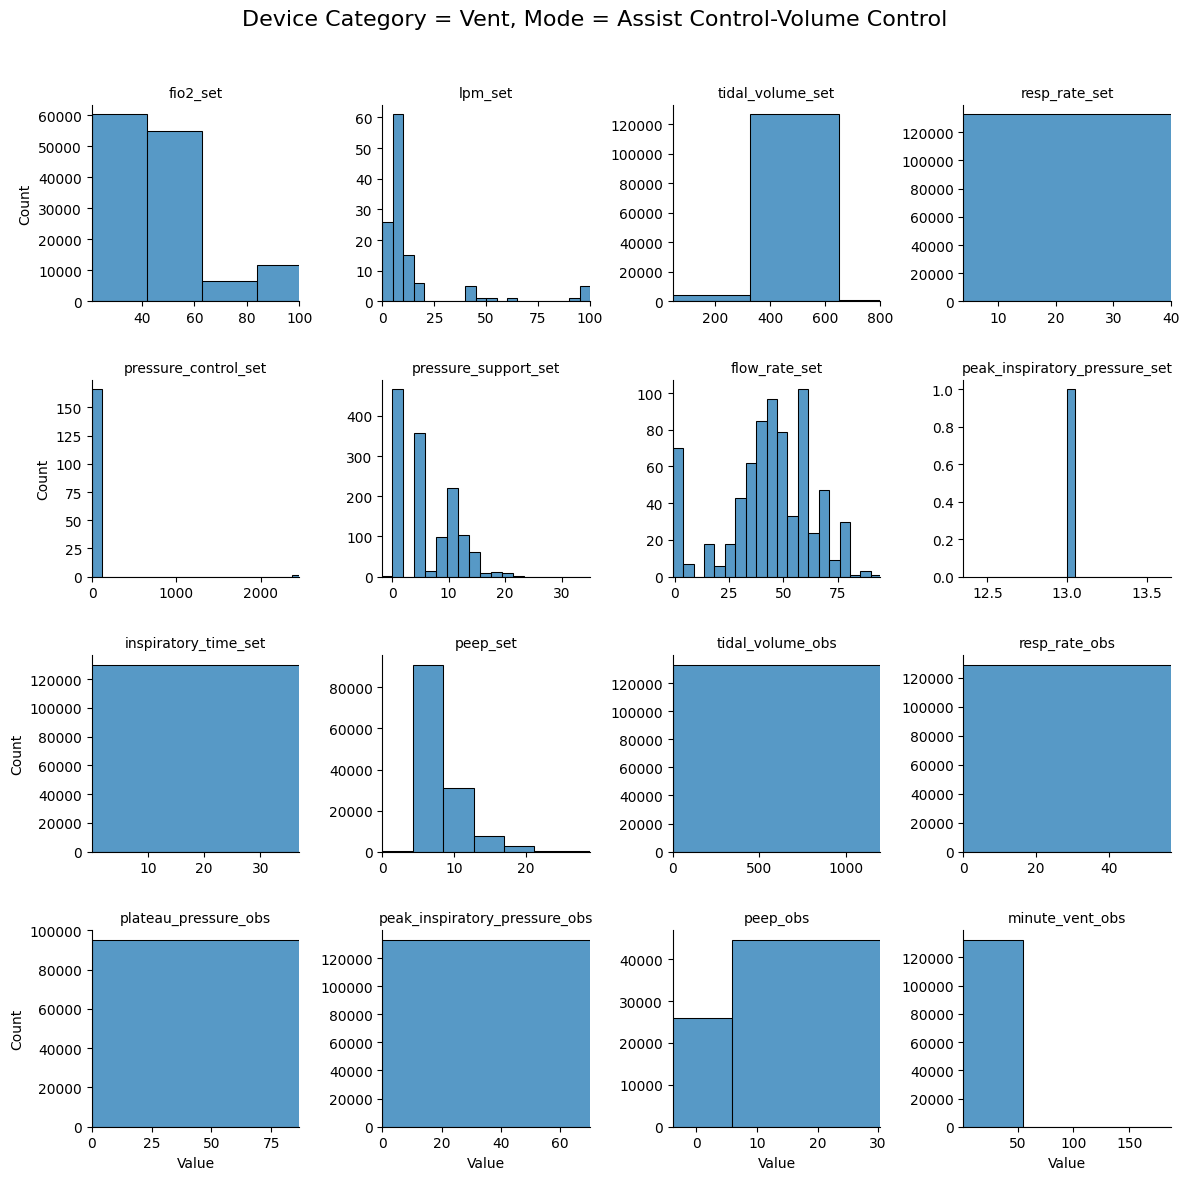

In [75]:
plot_histograms_by_device_category(resp_final, "Vent", "Assist Control-Volume Control")

# `labs` table

## utils

In [19]:
def item_id_to_uom_instances_categorical(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Return all the unique categories
    '''
    print(f"checking lab item {item_id}")
    assoc_events = events.loc[events["itemid"] == item_id, :]
    categories = assoc_events.value_counts("valueuom").to_dict()
    return str(categories)

In [20]:
labevents.value_counts("itemid")

itemid
51221    3325700
50912    3282278
51265    3216656
51006    3189474
51222    3188835
          ...   
51459          1
51927          1
52392          1
52113          1
52294          1
Length: 915, dtype: int64

In [21]:
def gen_lab_item_candidate_table(kw, blood_only = True, 
                                 case = False):  
    lab_items_select = d_labitems[d_labitems["label"].str.contains(kw,case=case, na=False)]
    if blood_only:
        lab_items_select = lab_items_select[(d_labitems["fluid"] == "Blood")]
    
    lab_counts = labevents.value_counts("itemid")
    lab_counts.name = "count"
    
    lab_items_cand = (
        lab_items_select
        .join(lab_counts, on = "itemid")
        .loc[lambda df: df["count"].notna(), :]
        .sort_values("count", ascending=False)
    )
    
    # add values instances
    lab_items_cand["value_instances"] = lab_items_cand["itemid"].apply(
        lambda x: item_id_to_value_instances_numeric(x, labevents)
        )

    # add valueuom instances
    lab_items_cand["uom_instances"] = lab_items_cand["itemid"].apply(
        lambda x: item_id_to_uom_instances_categorical(x, labevents)
        )
    
    return lab_items_cand

## EDA

In [103]:
item_id_to_label(223830)

2024-08-13 16:09:32,840:INFO:the label for item 223830 is PH (Arterial)


'PH (Arterial)'

In [23]:
ItemFinder("PH", case_sensitive=True, for_labs=True).candidate_table

2024-08-13 23:35:58,203:INFO:8 matching item(s) found.


2024-08-13 23:36:01,141:INFO:type is <class 'pandas.core.series.Series'>
2024-08-13 23:36:01,148:INFO:the label for item 223830 is PH (Arterial)
2024-08-13 23:36:01,150:INFO:the param_type for item 223830 (PH (Arterial)) is Numeric
2024-08-13 23:36:01,493:INFO:the label for item 220274 is PH (Venous)
2024-08-13 23:36:01,496:INFO:the param_type for item 220274 (PH (Venous)) is Numeric


item label: PH (Arterial); value instances: Max: 999999.0, Min: 0.0, Mean: 139.91


2024-08-13 23:36:01,798:INFO:the label for item 220734 is PH (dipstick)
2024-08-13 23:36:01,801:INFO:the param_type for item 220734 (PH (dipstick)) is Numeric


item label: PH (Venous); value instances: Max: 999999.0, Min: 0.0, Mean: 246.98


2024-08-13 23:36:02,096:INFO:the label for item 223259 is Insulin - NPH
2024-08-13 23:36:02,099:INFO:the param_type for item 223259 (Insulin - NPH) is Solution
2024-08-13 23:36:02,101:INFO:the label for item 226769 is PHApacheIIValue
2024-08-13 23:36:02,104:INFO:the param_type for item 226769 (PHApacheIIValue) is Numeric


item label: PH (dipstick); value instances: Max: 9.0, Min: 5.0, Mean: 5.97


2024-08-13 23:36:02,389:INFO:the label for item 227038 is PHPaCO2Score_ApacheIV
2024-08-13 23:36:02,392:INFO:the param_type for item 227038 (PHPaCO2Score_ApacheIV) is Numeric


item label: PHApacheIIValue; value instances: Max: 7.43, Min: 7.08, Mean: 7.23


2024-08-13 23:36:02,678:INFO:the label for item 227037 is PH_ApacheIV
2024-08-13 23:36:02,681:INFO:the param_type for item 227037 (PH_ApacheIV) is Numeric


item label: PHPaCO2Score_ApacheIV; value instances: Max: 9.0, Min: 0.0, Mean: 3.12


2024-08-13 23:36:02,966:INFO:the label for item 228243 is PH (SOFT)
2024-08-13 23:36:02,969:INFO:the param_type for item 228243 (PH (SOFT)) is Numeric


item label: PH_ApacheIV; value instances: Max: 7.52, Min: 7.24, Mean: 7.36
item label: PH (SOFT); value instances: Max: nan, Min: nan, Mean: nan


itemid                  label           abbreviation      linksto  \
382   223830          PH (Arterial)          PH (Arterial)  chartevents   
35    220274            PH (Venous)            PH (Venous)  chartevents   
158   220734          PH (dipstick)          PH (dipstick)  chartevents   
325   223259          Insulin - NPH          Insulin - NPH  inputevents   
1979  226769        PHApacheIIValue        PHApacheIIValue  chartevents   
2081  227038  PHPaCO2Score_ApacheIV  PHPaCO2Score_ApacheIV  chartevents   
2080  227037            PH_ApacheIV            PH_ApacheIV  chartevents   
2777  228243              PH (SOFT)              PH (SOFT)  chartevents   

                    category     count                        value_instances  \
382                     Labs  316903.0  Max: 999999.0, Min: 0.0, Mean: 139.91   
35                      Labs   62600.0  Max: 999999.0, Min: 0.0, Mean: 246.98   
158                     Labs   40988.0         Max: 9.0, Min: 5.0, Mean: 5.97   
325              Medications    7080.0                               Solution   
1979      Scores - APACHE II      14.0       Max: 7.43, Min: 7.08, Mean: 7.23   
2081  Scores - APACHE IV (2)       8.0         Max: 9.0, Min: 0.0, Mean: 3.12   
2080  Scores - APACHE IV (2)       5.0       Max: 7.52, Min: 7.24, Mean: 7.36   
2777                    Labs       NaN          Max: nan, Min: nan, Mean: nan   

     unitname  
382      None  
35       None  
158      None  
325     units  
1979     None  
2081     None  
2080     None  
2777     None

In [108]:
item_id_to_events_df(223830)

2024-08-13 17:03:42,570:INFO:the linksto for item 223830 (PH (Arterial)) is chartevents


subject_id   hadm_id   stay_id                 time  itemid value  \
18842        10001884  26184834  37510196  2131-01-12 21:04:00  223830  7.38   
18849        10001884  26184834  37510196  2131-01-13 02:28:00  223830  7.42   
18929        10001884  26184834  37510196  2131-01-14 07:05:00  223830  7.46   
20752        10002013  23581541  39060235  2160-05-18 10:26:00  223830  7.35   
20765        10002013  23581541  39060235  2160-05-18 11:23:00  223830   7.4   
...               ...       ...       ...                  ...     ...   ...   
313642192    19999840  21033226  38978960  2164-09-15 16:30:00  223830   7.4   
313642265    19999840  21033226  38978960  2164-09-17 08:11:00  223830  7.42   
313642307    19999840  21033226  38978960  2164-09-17 13:34:00  223830  7.27   
313645025    19999987  23865745  36195440  2145-11-03 05:28:00  223830  7.39   
313645049    19999987  23865745  36195440  2145-11-04 07:18:00  223830  7.42   

          valueuom  
18842        units  
18849        units  
18929        units  
20752        units  
20765        units  
...            ...  
313642192    units  
313642265    units  
313642307    units  
313645025    units  
313645049    units  

[316903 rows x 7 columns]

In [115]:
labevents[labevents["itemid"] == 50828].value_counts("value")

value
CONTROLLED.     42556
SPONTANEOUS.    13534
IMV.              567
dtype: int64

In [27]:
o2_items = ItemFinder("O2", for_labs = True).candidate_table

2024-08-14 00:14:03,886:INFO:63 matching item(s) found.


2024-08-14 00:14:09,081:INFO:type is <class 'pandas.core.series.Series'>


itemid                                     label  \
36    220277               O2 saturation pulseoxymetry   
1946  226732                     O2 Delivery Device(s)   
384   223835                      Inspired O2 Fraction   
346   223770   O2 Saturation Pulseoxymetry Alarm - Low   
345   223769  O2 Saturation Pulseoxymetry Alarm - High   
...      ...                                       ...   
2007  226863              PVR %O2 Saturation (PA Line)   
2008  226865              SVR %O2 Saturation (PA Line)   
2052  227009                         FiO2_ApacheIV_old   
2376  227685                   ZCentral Venous O2% Sat   
2867  228371                              DO2I (NICOM)   

                      abbreviation      linksto                category  \
36                            SpO2  chartevents             Respiratory   
1946         O2 Delivery Device(s)  chartevents             Respiratory   
384                           FiO2  chartevents             Respiratory   
346               SpO2 Alarm - Low  chartevents                  Alarms   
345              SpO2 Alarm - High  chartevents                  Alarms   
...                            ...          ...                     ...   
2007  PVR %O2 Saturation (PA Line)  chartevents       PA Line Insertion   
2008  SVR %O2 Saturation (PA Line)  chartevents       PA Line Insertion   
2052             FiO2_ApacheIV_old  chartevents  Scores - APACHE IV (2)   
2376       ZCentral Venous O2% Sat  chartevents                    Labs   
2867                  DO2I (NICOM)  chartevents                   NICOM   

          count                                    value_instances  \
36    6324341.0          Max: 9900000.0, Min: -272.0, Mean: 104.83   
1946  1536870.0  {'Endotracheal tube': 467931, 'Nasal cannula':...   
384    849875.0                Max: 10050.0, Min: 0.0, Mean: 48.95   
346    622764.0           Max: 9210080.0, Min: -92.0, Mean: 108.74   
345    619601.0              Max: 100185.0, Min: 0.0, Mean: 102.25   
...         ...                                                ...   
2007        NaN                      Max: nan, Min: nan, Mean: nan   
2008        NaN                      Max: nan, Min: nan, Mean: nan   
2052        NaN                      Max: nan, Min: nan, Mean: nan   
2376        NaN                      Max: nan, Min: nan, Mean: nan   
2867        NaN                      Max: nan, Min: nan, Mean: nan   

           unitname  
36                %  
1946            NaN  
384            None  
346               %  
345               %  
...             ...  
2007  dynes*sec/cm5  
2008  dynes*sec/cm5  
2052           None  
2376           None  
2867      mL/min/m2  

[63 rows x 8 columns]

# `medication_admin_continuous` table

## utils

In [50]:
emar = load_mimic_table("hosp", "emar", "pq")
emar_detail = load_mimic_table("hosp", "emar_detail", "pq")

/tmp/ipykernel_26217/764160326.py:5: DtypeWarning: Columns (8,11,14,19,20,22,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f'../mimic-iv-2.2/{module}/{table}.csv.gz')


In [51]:
emar.to_parquet("../mimic-iv-2.2/hosp/emar.parquet")
emar_detail.to_parquet("../mimic-iv-2.2/hosp/emar_detail.parquet")

ArrowTypeError: ("Expected bytes, got a 'float' object", 'Conversion failed for column dose_given with type object')

In [72]:
ingredientevents = load_mimic_table("icu", "ingredientevents", "csv")

## EDA

In [81]:
inputevents.value_counts("ordercategorydescription")

ordercategorydescription
Continuous Med    3725846
Drug Push         2506912
Continuous IV     1495015
Bolus             1232089
Non Iv Meds         19031
Name: count, dtype: int64

In [87]:
d_items.dtypes

itemid               int64
label               object
abbreviation        object
linksto             object
category            object
unitname            object
param_type          object
lownormalvalue     float64
highnormalvalue    float64
dtype: object

In [88]:
d_items.set_index("itemid", inplace=True)

In [95]:
rate_label = inputevents[["itemid", "rate", "rateuom", "ordercategorydescription"]].join(d_items, on = "itemid")
rate_label

itemid        rate   rateuom ordercategorydescription  \
0        226452         NaN       NaN                    Bolus   
1        226452         NaN       NaN                    Bolus   
2        220862  100.000000   mL/hour            Continuous IV   
3        220862  100.000000   mL/hour            Continuous IV   
4        226452         NaN       NaN                    Bolus   
...         ...         ...       ...                      ...   
8978888  225942   75.000008  mcg/hour           Continuous Med   
8978889  225943    1.500000   mL/hour           Continuous Med   
8978890  225158   75.282310   mL/hour            Continuous IV   
8978891  226452         NaN       NaN                    Bolus   
8978892  226089   10.285714   mL/hour            Continuous IV   

                          label            abbreviation      linksto  \
0                     PO Intake               PO Intake  inputevents   
1                     PO Intake               PO Intake  inputevents   
2                   Albumin 25%             Albumin 25%  inputevents   
3                   Albumin 25%             Albumin 25%  inputevents   
4                     PO Intake               PO Intake  inputevents   
...                         ...                     ...          ...   
8978888  Fentanyl (Concentrate)  Fentanyl (Concentrate)  inputevents   
8978889                Solution                Solution  inputevents   
8978890               NaCl 0.9%               NaCl 0.9%  inputevents   
8978891               PO Intake               PO Intake  inputevents   
8978892               Piggyback               Piggyback  inputevents   

                        category unitname param_type  lownormalvalue  \
0                  Fluids/Intake       mL   Solution             NaN   
1                  Fluids/Intake       mL   Solution             NaN   
2        Blood Products/Colloids       mL   Solution             NaN   
3        Blood Products/Colloids       mL   Solution             NaN   
4                  Fluids/Intake       mL   Solution             NaN   
...                          ...      ...        ...             ...   
8978888              Medications       mg   Solution             NaN   
8978889            Fluids/Intake       mL   Solution             NaN   
8978890            Fluids/Intake       mL   Solution             NaN   
8978891            Fluids/Intake       mL   Solution             NaN   
8978892            Fluids/Intake       mL   Solution             NaN   

         highnormalvalue  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
8978888              NaN  
8978889              NaN  
8978890              NaN  
8978891              NaN  
8978892              NaN  

[8978893 rows x 12 columns]

In [89]:
cont = inputevents.loc[
    inputevents["ordercategorydescription"].isin(["Continuous Med", "Continuous IV"]), :
].join(d_items, on = "itemid")

In [91]:
cont_label = cont.value_counts(["ordercategorydescription","label"])
cont_label

ordercategorydescription  label                      
Continuous Med            NaCl 0.9%                      779313
                          Dextrose 5%                    565131
                          Solution                       465997
                          Norepinephrine                 336000
                          Propofol                       321426
                                                          ...  
                          NaCl 0.45%                          1
Continuous IV             Enlive (Full)                       1
                          Pulmocare (1/4)                     1
                          Ensure (3/4)                        1
                          Boost Glucose Control (1/4)         1
Name: count, Length: 219, dtype: int64

In [80]:
item_id_to_label(227523)

searching for the label of item 227523


'Magnesium Sulfate (Bolus)'

In [60]:
ItemFinder("norepinephrine").candidate_table

itemid           label    abbreviation      linksto     category  \
305  221906  Norepinephrine  Norepinephrine  inputevents  Medications   

    unitname param_type   count value_instances  
305       mg   Solution  336000        Solution

In [61]:
ItemFinder("epinephrine").candidate_table

searching for the label of item 221289
searching for the param_type of item 221289
searching for the label of item 229617
searching for the param_type of item 229617


itemid           label    abbreviation      linksto     category  \
305   221906  Norepinephrine  Norepinephrine  inputevents  Medications   
280   221289     Epinephrine     Epinephrine  inputevents  Medications   
3737  229617    Epinephrine.    Epinephrine.  inputevents  Medications   

     unitname param_type   count value_instances  
305        mg   Solution  336000        Solution  
280        mg   Solution   24470        Solution  
3737       mg   Solution     133        Solution

In [65]:
ItemFinder("nicardipine").candidate_table

searching for the label of item 222042
searching for the param_type of item 222042
searching for the label of item 229624
searching for the param_type of item 229624


itemid                 label          abbreviation      linksto  \
310   222042           Nicardipine           Nicardipine  inputevents   
3741  229624  Nicardipine 40mg/200  Nicardipine 40mg/200  inputevents   

         category unitname param_type  count value_instances  
310   Medications       mg   Solution  37307        Solution  
3741  Medications       mg   Solution  10376        Solution

In [75]:
ItemFinder("rocuronium").candidate_table

searching for the label of item 229233
searching for the param_type of item 229233
searching for the label of item 229788
searching for the param_type of item 229788
item label: Rocuronium (Intubation); value instances: Max: nan, Min: nan, Mean: nan


itemid                    label             abbreviation      linksto  \
3463  229233               Rocuronium               Rocuronium  inputevents   
3869  229788  Rocuronium (Intubation)  Rocuronium (Intubation)  chartevents   

         category unitname param_type   count                value_instances  
3463  Medications       mg   Solution  2458.0                       Solution  
3869   Intubation       mg    Numeric     NaN  Max: nan, Min: nan, Mean: nan

In [96]:
item_id_to_label(227523)

'Magnesium Sulfate (Bolus)'

# `dialysis` table

## utils

In [46]:
pe_col_names = ['index', 'hadm_id', 'starttime', 'endtime', 'storetime', 'value', "valueuom"]
ce_col_names = ['index', 'hadm_id', 'charttime', 'storetime', 'valuenum', "valueuom"]

In [18]:
crrt_events = item_id_to_events_df(225802)
crrt_events = convert_and_sort_datetime(crrt_events, "pe")

searching for the linksto of item 225802


/tmp/ipykernel_25622/1017478986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["starttime"] = pd.to_datetime(df["starttime"])
/tmp/ipykernel_25622/1017478986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["endtime"] = pd.to_datetime(df["endtime"])


In [19]:
uf_events = item_id_to_events_df(226457)
uf_events = convert_and_sort_datetime(uf_events, "ce")

searching for the linksto of item 226457


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


In [20]:
dr_events = item_id_to_events_df(224154)
dr_events = convert_and_sort_datetime(dr_events, "ce")

searching for the linksto of item 224154


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


In [21]:
dr_events.head(20)

index  subject_id   hadm_id   stay_id  caregiver_id           charttime  \
0       0    17656146  20003587  34504641       48770.0 2146-04-17 16:30:00   
1       1    17656146  20003587  34504641       92805.0 2146-04-17 18:00:00   
2       2    11423795  20012928  30003226       32851.0 2123-02-27 08:26:00   
3       3    11423795  20012928  30003226       32851.0 2123-02-27 08:27:00   
4       4    11423795  20012928  30003226       32851.0 2123-02-27 10:00:00   
5       5    11423795  20012928  30003226       32851.0 2123-02-27 12:00:00   
6       6    11423795  20012928  30003226       32851.0 2123-02-27 14:00:00   
7       7    17844820  20014219  38957578       36212.0 2142-10-15 20:35:00   
8       8    17844820  20014219  38957578       36212.0 2142-10-15 21:00:00   
9       9    17844820  20014219  38957578       36212.0 2142-10-15 22:00:00   
10     10    17844820  20014219  38957578       36212.0 2142-10-15 23:00:00   
11     11    17844820  20014219  38957578       36212.0 2142-10-16 00:00:00   
12     12    17844820  20014219  38957578       36212.0 2142-10-16 01:00:00   
13     13    17844820  20014219  38957578       36212.0 2142-10-16 02:00:00   
14     14    17844820  20014219  38957578       36212.0 2142-10-16 03:00:00   
15     15    17844820  20014219  38957578       36212.0 2142-10-16 04:00:00   
16     16    17844820  20014219  38957578       36212.0 2142-10-16 05:00:00   
17     17    17844820  20014219  38957578       36212.0 2142-10-16 06:00:00   
18     18    17844820  20014219  38957578       15977.0 2142-10-16 07:00:00   
19     19    17844820  20014219  38957578       15977.0 2142-10-16 08:18:00   

              storetime  itemid value  valuenum valueuom  warning  
0   2146-04-17 16:45:00  224154   500     500.0    ml/hr      0.0  
1   2146-04-17 18:17:00  224154   500     500.0    ml/hr      0.0  
2   2123-02-27 08:27:00  224154  1000    1000.0    ml/hr      0.0  
3   2123-02-27 08:27:00  224154  1000    1000.0    ml/hr      0.0  
4   2123-02-27 14:20:00  224154  1000    1000.0    ml/hr      0.0  
5   2123-02-27 14:20:00  224154  1000    1000.0    ml/hr      0.0  
6   2123-02-27 14:20:00  224154  1000    1000.0    ml/hr      0.0  
7   2142-10-15 20:36:00  224154   800     800.0    ml/hr      0.0  
8   2142-10-15 21:06:00  224154   800     800.0    ml/hr      0.0  
9   2142-10-15 22:15:00  224154   800     800.0    ml/hr      0.0  
10  2142-10-15 23:09:00  224154   800     800.0    ml/hr      0.0  
11  2142-10-16 00:36:00  224154   800     800.0    ml/hr      0.0  
12  2142-10-16 01:13:00  224154   800     800.0    ml/hr      0.0  
13  2142-10-16 02:11:00  224154   800     800.0    ml/hr      0.0  
14  2142-10-16 03:05:00  224154   800     800.0    ml/hr      0.0  
15  2142-10-16 04:14:00  224154   800     800.0    ml/hr      0.0  
16  2142-10-16 05:06:00  224154   800     800.0    ml/hr      0.0  
17  2142-10-16 06:23:00  224154   800     800.0    ml/hr      0.0  
18  2142-10-16 08:17:00  224154   800     800.0    ml/hr      0.0  
19  2142-10-16 08:19:00  224154   800     800.0    ml/hr      0.0

### IHD

In [162]:
hd_events = item_id_to_events_df(225441)
hd_events = convert_and_sort_datetime(hd_events, "pe") # [pe_col_names]
hd_events['value_hr'] = np.where(hd_events['valueuom'] == 'min', round(hd_events['value'] / 60, 2), hd_events['value'])
hd_events.drop(columns = ["value", "valueuom"], inplace=True)
hd_events

searching for the linksto of item 225441


/tmp/ipykernel_25622/1017478986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["starttime"] = pd.to_datetime(df["starttime"])
/tmp/ipykernel_25622/1017478986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["endtime"] = pd.to_datetime(df["endtime"])


index  subject_id   hadm_id   stay_id  caregiver_id           starttime  \
0         0    15783916  20009550  34591776       49107.0 2120-11-07 09:10:00   
1         1    11423795  20012928  30003226           NaN 2123-02-28 09:15:00   
2         2    18549459  20021612  34145253       82783.0 2162-05-07 13:10:00   
3         3    16512720  20030303  31909884       27726.0 2158-03-15 07:10:00   
4         4    13158454  20033924  39190238           NaN 2196-05-01 08:16:00   
...     ...         ...       ...       ...           ...                 ...   
4355   4355    18069196  29992506  35483229       41588.0 2201-08-29 07:30:00   
4356   4356    18069196  29992506  35483229       64055.0 2201-09-04 08:30:00   
4357   4357    18069196  29992506  35812325       82148.0 2201-09-09 13:00:00   
4358   4358    18069196  29992506  35812325       73189.0 2201-09-11 12:06:00   
4359   4359    12151711  29993312  36345004       56732.0 2163-10-20 08:27:00   

                 endtime                storetime  itemid location  ...  \
0    2120-11-07 13:10:00      2120-11-07 14:49:00  225441      NaN  ...   
1    2123-02-28 15:33:00  2123-02-28 15:33:53.177  225441      NaN  ...   
2    2162-05-07 16:23:00      2162-05-07 17:07:00  225441      NaN  ...   
3    2158-03-15 10:10:00      2158-03-15 08:17:00  225441      NaN  ...   
4    2196-05-01 14:23:00   2196-05-01 14:23:05.65  225441      NaN  ...   
...                  ...                      ...     ...      ...  ...   
4355 2201-08-29 11:00:00      2201-08-29 11:27:00  225441      NaN  ...   
4356 2201-09-04 12:01:00      2201-09-04 14:04:00  225441      NaN  ...   
4357 2201-09-09 15:53:00      2201-09-09 16:27:00  225441      NaN  ...   
4358 2201-09-11 15:57:00      2201-09-11 18:05:00  225441      NaN  ...   
4359 2163-10-20 11:23:00      2163-10-20 11:41:00  225441      NaN  ...   

     linkorderid      ordercategoryname  ordercategorydescription  \
0        5154974  Continuous Procedures         ContinuousProcess   
1        6102757  Continuous Procedures         ContinuousProcess   
2        3622293  Continuous Procedures         ContinuousProcess   
3        6521528  Continuous Procedures         ContinuousProcess   
4        8238820  Continuous Procedures         ContinuousProcess   
...          ...                    ...                       ...   
4355     1875851  Continuous Procedures         ContinuousProcess   
4356     9197079  Continuous Procedures         ContinuousProcess   
4357     2813325  Continuous Procedures         ContinuousProcess   
4358     3548426  Continuous Procedures         ContinuousProcess   
4359     2641074  Continuous Procedures         ContinuousProcess   

     patientweight isopenbag  continueinnextdept  statusdescription  \
0             81.4         1                   0    FinishedRunning   
1             91.8         1                   0    FinishedRunning   
2             85.0         1                   0    FinishedRunning   
3             43.5         0                   0    FinishedRunning   
4             68.0         1                   0    FinishedRunning   
...            ...       ...                 ...                ...   
4355          68.4         1                   0    FinishedRunning   
4356          68.4         1                   0    FinishedRunning   
4357          68.4         1                   0    FinishedRunning   
4358          68.4         1                   0    FinishedRunning   
4359         107.8         1                   0    FinishedRunning   

      originalamount originalrate  value_hr  
0              240.0            1      4.00  
1              378.0            1      6.30  
2              193.0            1      3.22  
3                3.0            1      3.00  
4              367.0            1      6.12  
...              ...          ...       ...  
4355           210.0            1      3.50  
4356           211.0            1      3.52  
4357           173.0            1   

In [170]:
hdo_events = item_id_to_events_df(226499)
hdo_events = convert_and_sort_datetime(hdo_events, "ce")
hdo_events

searching for the linksto of item 226499


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


index  subject_id   hadm_id   stay_id  caregiver_id           charttime  \
0         0    11423795  20012928  30003226       72136.0 2123-02-28 12:55:00   
1         1    18549459  20021612  34145253       82783.0 2162-05-07 17:07:00   
2         2    16123839  20026358  39945216       55876.0 2145-08-11 19:00:00   
3         3    16512720  20030303  31909884       27726.0 2158-03-15 10:19:00   
4         4    14454179  20050595  33639449        1215.0 2202-12-01 21:37:00   
...     ...         ...       ...       ...           ...                 ...   
4849   4849    13746897  29990494  38283802       32221.0 2171-05-27 13:30:00   
4850   4850    18069196  29992506  35483229       41588.0 2201-08-29 10:00:00   
4851   4851    18069196  29992506  35812325       82148.0 2201-09-09 15:50:00   
4852   4852    18069196  29992506  35812325       73189.0 2201-09-11 15:52:00   
4853   4853    12151711  29993312  36345004       56732.0 2163-10-20 11:23:00   

                storetime  itemid value  valuenum valueuom  warning  
0     2123-02-28 12:56:00  226499  1200    1200.0       mL      0.0  
1     2162-05-07 17:07:00  226499  1800    1800.0       mL      0.0  
2     2145-08-11 20:24:00  226499  1000    1000.0       mL      0.0  
3     2158-03-15 10:20:00  226499  4000    4000.0       mL      0.0  
4     2202-12-02 00:37:00  226499  2000    2000.0       mL      0.0  
...                   ...     ...   ...       ...      ...      ...  
4849  2171-05-27 13:30:00  226499   500     500.0       mL      0.0  
4850  2201-08-29 10:20:00  226499  1400    1400.0       mL      0.0  
4851  2201-09-09 16:28:00  226499   750     750.0       mL      1.0  
4852  2201-09-11 15:52:00  226499  1400    1400.0       mL      0.0  
4853  2163-10-20 11:06:00  226499  1200    1200.0       mL      0.0  

[4854 rows x 12 columns]

In [24]:
# hourly patient fluid removal
hfr_events = item_id_to_events_df(224191)
hfr_events = convert_and_sort_datetime(hfr_events, "ce")
hfr_events

searching for the linksto of item 224191


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


index  subject_id   hadm_id   stay_id  caregiver_id  \
0            0    17656146  20003587  34504641       48770.0   
1            1    17656146  20003587  34504641       48770.0   
2            2    17656146  20003587  34504641       92805.0   
3            3    11423795  20012928  30003226       32851.0   
4            4    11423795  20012928  30003226       32851.0   
...        ...         ...       ...       ...           ...   
209421  209421    18069196  29992506  35483229       40714.0   
209422  209422    18069196  29992506  35483229       40714.0   
209423  209423    18069196  29992506  35483229       40714.0   
209424  209424    18069196  29992506  35483229       40714.0   
209425  209425    18069196  29992506  35483229       40714.0   

                 charttime            storetime  itemid value  valuenum  \
0      2146-04-17 16:30:00  2146-04-17 16:45:00  224191   570     570.0   
1      2146-04-17 17:00:00  2146-04-17 17:05:00  224191   630     630.0   
2      2146-04-17 18:00:00  2146-04-17 18:23:00  224191   480     480.0   
3      2123-02-27 08:26:00  2123-02-27 08:27:00  224191     0       0.0   
4      2123-02-27 10:00:00  2123-02-27 14:20:00  224191   230     230.0   
...                    ...                  ...     ...   ...       ...   
209421 2201-09-02 14:00:00  2201-09-02 14:10:00  224191   250     250.0   
209422 2201-09-02 15:00:00  2201-09-02 16:07:00  224191   250     250.0   
209423 2201-09-02 16:00:00  2201-09-02 16:07:00  224191   250     250.0   
209424 2201-09-02 17:00:00  2201-09-02 17:29:00  224191   250     250.0   
209425 2201-09-02 18:00:00  2201-09-02 18:23:00  224191   250     250.0   

       valueuom  warning  
0            mL      0.0  
1            mL      0.0  
2            mL      0.0  
3            mL      0.0  
4            mL      0.0  
...         ...      ...  
209421       mL      0.0  
209422       mL      0.0  
209423       mL      0.0  
209424       mL      0.0  
209425       mL      0.0  

[209426 rows x 12 columns]

In [25]:
rr_events = item_id_to_events_df(224153)
rr_events = convert_and_sort_datetime(rr_events, "ce")
rr_events.head()

searching for the linksto of item 224153


/tmp/ipykernel_25622/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


index  subject_id   hadm_id   stay_id  caregiver_id           charttime  \
0      0    17656146  20003587  34504641       48770.0 2146-04-17 16:30:00   
1      1    17656146  20003587  34504641       92805.0 2146-04-17 18:00:00   
2      2    11423795  20012928  30003226       32851.0 2123-02-27 08:26:00   
3      3    11423795  20012928  30003226       32851.0 2123-02-27 08:27:00   
4      4    11423795  20012928  30003226       32851.0 2123-02-27 10:00:00   

             storetime  itemid value  valuenum valueuom  warning  
0  2146-04-17 16:45:00  224153  2800    2800.0    ml/hr      0.0  
1  2146-04-17 18:23:00  224153  2800    2800.0    ml/hr      0.0  
2  2123-02-27 08:27:00  224153   200     200.0    ml/hr      0.0  
3  2123-02-27 08:27:00  224153   200     200.0    ml/hr      0.0  
4  2123-02-27 14:20:00  224153   200     200.0    ml/hr      0.0

### mapping between CE and PE

In [26]:
# see how many chart events does a super long HD cover
def find_ce_within_pe(pe_df, pe_idx, ce_df, buffer_hours: int = 1):
    '''
    Find the chart events that are covered by a procedure event.
    '''
    pe_row = pe_df[pe_df["index"] == pe_idx]
    hadm_id = pe_row["hadm_id"].values[0]
    starttime = pd.to_datetime(pe_row["starttime"].values[0])
    endtime = pd.to_datetime(pe_row["endtime"].values[0])
    
    ce_select = ce_df.loc[
        (ce_df["hadm_id"] == hadm_id) & 
        (starttime - timedelta(hours = buffer_hours) <= ce_df["charttime"]) &
        (ce_df["charttime"] <= endtime + timedelta(hours = buffer_hours))
    ]
    
    return pd.merge(
        pe_row[pe_col_names], ce_select[ce_col_names],
        how = "outer", on = "hadm_id", indicator = True
    )

## EDA

In [19]:
# search by category name
dial_items = ItemFinder(kw = "Dialysis", col = "category").candidate_table.loc[
    lambda df: df["count"].isna(), :
]
dial_items

itemid                            label  \
561   224135             Dialysis Access Site   
562   224139         Dialysis Site Appearance   
1543  225803                 Dialysis - CVVHD   
1547  225809                Dialysis - CVVHDF   
1657  225955                  Dialysis - SCUF   
2199  227438               Volume not removed   
4011  230083   Replacement Fluid (Pre-Filter)   
4012  230084  Replacement Fluid (Post-Filter)   
4013  230085                  Dialysate Fluid   

                         abbreviation          linksto  category unitname  \
561              Dialysis Access Site      chartevents  Dialysis      NaN   
562          Dialysis Site Appearance      chartevents  Dialysis      NaN   
1543                 Dialysis - CVVHD  procedureevents  Dialysis      NaN   
1547                Dialysis - CVVHDF  procedureevents  Dialysis      NaN   
1657                  Dialysis - SCUF  procedureevents  Dialysis      NaN   
2199               Volume not removed      chartevents  Dialysis       mL   
4011   Replacement Fluid (Pre-Filter)      chartevents  Dialysis      NaN   
4012  Replacement Fluid (Post-Filter)      chartevents  Dialysis      NaN   
4013                  Dialysate Fluid      chartevents  Dialysis      NaN   

     param_type  count                value_instances  
561        Text    NaN                             {}  
562        Text    NaN                             {}  
1543  Processes    NaN                      Processes  
1547  Processes    NaN                      Processes  
1657  Processes    NaN                      Processes  
2199    Numeric    NaN  Max: nan, Min: nan, Mean: nan  
4011       Text    NaN                             {}  
4012       Text    NaN                             {}  
4013       Text    NaN                             {}

In [127]:
output_items = d_items[d_items["linksto"].str.contains("outputevents", case = False, na = False)]
output_items

itemid                            label  \
717   224458                Drain Output_ingr   
1875  226557                 R Ureteral Stent   
1876  226558                 L Ureteral Stent   
1877  226559                            Foley   
1878  226560                             Void   
...      ...                              ...   
2245  227511               TF Residual Output   
2390  227701                     Drainage Bag   
2653  228103  Stool containment device placed   
3595  229413                    Chest Tube #3   
3596  229414                    Chest Tube #4   

                         abbreviation       linksto category unitname  \
717                 Drain Output_ingr  outputevents   Drains       mL   
1875                 R Ureteral Stent  outputevents   Output       mL   
1876                 L Ureteral Stent  outputevents   Output       mL   
1877                            Foley  outputevents   Output       mL   
1878                             Void  outputevents   Output       mL   
...                               ...           ...      ...      ...   
2245               TF Residual Output  outputevents   Output       mL   
2390                     Drainage Bag  outputevents   Drains       mL   
2653  Stool containment device placed  outputevents   Output      NaN   
3595                    Chest Tube #3  outputevents   Output       mL   
3596                    Chest Tube #4  outputevents   Output       mL   

         param_type  lownormalvalue  highnormalvalue  
717      Ingredient             NaN              NaN  
1875        Numeric             NaN              NaN  
1876        Numeric             NaN              NaN  
1877        Numeric             NaN              NaN  
1878        Numeric             NaN              NaN  
...             ...             ...              ...  
2245        Numeric             NaN              NaN  
2390        Numeric             NaN              NaN  
2653  Date and time             NaN              NaN  
3595        Numeric             NaN              NaN  
3596        Numeric             NaN              NaN  

[77 rows x 9 columns]

In [121]:
procedureevents[procedureevents["itemid"]==225804]

Empty DataFrame
Columns: [subject_id, hadm_id, stay_id, caregiver_id, starttime, endtime, storetime, itemid, value, valueuom, location, locationcategory, orderid, linkorderid, ordercategoryname, ordercategorydescription, patientweight, isopenbag, continueinnextdept, statusdescription, originalamount, originalrate]
Index: []

[0 rows x 22 columns]

### crrt & uf

In [51]:
# exp with joining subsets
hadm_id_eg = 20068469 # with a lot of dialysis events

crrt_eg = crrt_events.head(10)[pe_col_names]
uf_eg = uf_events[uf_events["hadm_id"] == hadm_id_eg].head(5)[ce_col_names]
matched = pd.merge(crrt_eg, uf_eg, on = "hadm_id", indicator = True)
matched

index_x   hadm_id            starttime              endtime   value  \
0     71974  20068469  2131-10-31 19:00:00  2131-11-01 11:43:00  1003.0   
1     71974  20068469  2131-10-31 19:00:00  2131-11-01 11:43:00  1003.0   
2     71974  20068469  2131-10-31 19:00:00  2131-11-01 11:43:00  1003.0   
3     71974  20068469  2131-10-31 19:00:00  2131-11-01 11:43:00  1003.0   
4     71974  20068469  2131-10-31 19:00:00  2131-11-01 11:43:00  1003.0   
5     71986  20068469  2131-11-01 14:00:00  2131-11-03 08:24:00  2544.0   
6     71986  20068469  2131-11-01 14:00:00  2131-11-03 08:24:00  2544.0   
7     71986  20068469  2131-11-01 14:00:00  2131-11-03 08:24:00  2544.0   
8     71986  20068469  2131-11-01 14:00:00  2131-11-03 08:24:00  2544.0   
9     71986  20068469  2131-11-01 14:00:00  2131-11-03 08:24:00  2544.0   
10    71988  20068469  2131-11-03 10:30:00  2131-11-03 22:39:00   729.0   
11    71988  20068469  2131-11-03 10:30:00  2131-11-03 22:39:00   729.0   
12    71988  20068469  2131-11-03 10:30:00  2131-11-03 22:39:00   729.0   
13    71988  20068469  2131-11-03 10:30:00  2131-11-03 22:39:00   729.0   
14    71988  20068469  2131-11-03 10:30:00  2131-11-03 22:39:00   729.0   

     index_y            charttime  valuenum _merge  
0   32040092  2131-10-31 19:00:00     282.0   both  
1   32040139  2131-10-31 20:00:00     618.0   both  
2   32040317  2131-10-31 21:01:00     574.0   both  
3   32040512  2131-10-31 22:00:00     641.0   both  
4   32040523  2131-10-31 23:00:00     514.0   both  
5   32040092  2131-10-31 19:00:00     282.0   both  
6   32040139  2131-10-31 20:00:00     618.0   both  
7   32040317  2131-10-31 21:01:00     574.0   both  
8   32040512  2131-10-31 22:00:00     641.0   both  
9   32040523  2131-10-31 23:00:00     514.0   both  
10  32040092  2131-10-31 19:00:00     282.0   both  
11  32040139  2131-10-31 20:00:00     618.0   both  
12  32040317  2131-10-31 21:01:00     574.0   both  
13  32040512  2131-10-31 22:00:00     641.0   both  
14  32040523  2131-10-31 23:00:00     514.0   both

In [52]:
crrt_eg

index   hadm_id            starttime              endtime    value
0  533014  20003587  2146-04-17 16:30:00  2146-04-17 19:12:00    162.0
1   99691  20012928  2123-02-27 08:26:00  2123-02-27 17:09:00    523.0
2  545261  20014219  2142-10-15 20:06:00  2142-10-17 03:00:00   1854.0
3   98988  20015730  2116-12-27 00:17:00  2117-01-02 11:01:00   9284.0
4  509440  20022095  2136-09-25 23:30:00  2136-09-27 21:00:00   2730.0
5  644082  20032690  2149-04-09 23:44:00  2149-04-17 04:34:00  10370.0
6  448037  20068018  2184-07-22 10:00:00  2184-07-23 10:00:00   1440.0
7   71974  20068469  2131-10-31 19:00:00  2131-11-01 11:43:00   1003.0
8   71986  20068469  2131-11-01 14:00:00  2131-11-03 08:24:00   2544.0
9   71988  20068469  2131-11-03 10:30:00  2131-11-03 22:39:00    729.0

In [49]:
uf_eg

index  subject_id   hadm_id   stay_id            charttime  valuenum  \
436  32040092    11048381  20068469  32703334  2131-10-31 19:00:00     282.0   
437  32040139    11048381  20068469  32703334  2131-10-31 20:00:00     618.0   
438  32040317    11048381  20068469  32703334  2131-10-31 21:01:00     574.0   
439  32040512    11048381  20068469  32703334  2131-10-31 22:00:00     641.0   
440  32040523    11048381  20068469  32703334  2131-10-31 23:00:00     514.0   

    valueuom  
436       mL  
437       mL  
438       mL  
439       mL  
440       mL

In [57]:
# joining the full sample
full_matched = pd.merge(
    crrt_events[['index', 'hadm_id', 'starttime', 'endtime', 'itemid', 'value', 'valueuom']], 
    uf_events[['index', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'valueuom']], 
    on = "hadm_id", indicator = True
    )
full_matched

index_x   hadm_id            starttime              endtime  \
0         533014  20003587  2146-04-17 16:30:00  2146-04-17 19:12:00   
1         533014  20003587  2146-04-17 16:30:00  2146-04-17 19:12:00   
2         533014  20003587  2146-04-17 16:30:00  2146-04-17 19:12:00   
3          99691  20012928  2123-02-27 08:26:00  2123-02-27 17:09:00   
4          99691  20012928  2123-02-27 08:26:00  2123-02-27 17:09:00   
...          ...       ...                  ...                  ...   
1009179   560984  29992506  2201-08-30 22:00:00  2201-09-02 19:10:00   
1009180   560984  29992506  2201-08-30 22:00:00  2201-09-02 19:10:00   
1009181   560984  29992506  2201-08-30 22:00:00  2201-09-02 19:10:00   
1009182   560984  29992506  2201-08-30 22:00:00  2201-09-02 19:10:00   
1009183   560984  29992506  2201-08-30 22:00:00  2201-09-02 19:10:00   

         itemid_x   value valueuom_x    index_y            charttime  \
0          225802   162.0        min  240152089  2146-04-17 16:00:00   
1          225802   162.0        min  240152090  2146-04-17 17:00:00   
2          225802   162.0        min  240152139  2146-04-17 18:00:00   
3          225802   523.0        min   44466315  2123-02-27 09:00:00   
4          225802   523.0        min   44466333  2123-02-27 10:00:00   
...           ...     ...        ...        ...                  ...   
1009179    225802  4150.0        min  252734596  2201-09-02 16:00:00   
1009180    225802  4150.0        min  252734619  2201-09-02 17:00:00   
1009181    225802  4150.0        min  252752322  2201-09-02 18:00:00   
1009182    225802  4150.0        min  252752323  2201-09-02 19:00:00   
1009183    225802  4150.0        min  252746061  2201-09-04 16:00:00   

         itemid_y  valuenum valueuom_y _merge  
0          226457     245.0         mL   both  
1          226457     583.0         mL   both  
2          226457     455.0         mL   both  
3          226457     230.0         mL   both  
4          226457     217.0         mL   both  
...           ...       ...        ...    ...  
1009179    226457     242.0         mL   both  
1009180    226457     245.0         mL   both  
1009181    226457     270.0         mL   both  
1009182    226457      41.0         mL   both  
1009183    226457     100.0         mL   both  

[1009184 rows x 13 columns]

### crrt & dialysate

In [31]:
# joining the full sample
crrt_dr_matched = pd.merge(
    crrt_events[['index', 'hadm_id', 'starttime', 'endtime', 'itemid', 'value', 'valueuom']], 
    dr_events[['index', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'valueuom']], 
    on = "hadm_id", indicator = True
    )
crrt_dr_matched.head(20)

index_x   hadm_id           starttime             endtime  itemid_x  \
0    533014  20003587 2146-04-17 16:30:00 2146-04-17 19:12:00    225802   
1    533014  20003587 2146-04-17 16:30:00 2146-04-17 19:12:00    225802   
2     99691  20012928 2123-02-27 08:26:00 2123-02-27 17:09:00    225802   
3     99691  20012928 2123-02-27 08:26:00 2123-02-27 17:09:00    225802   
4     99691  20012928 2123-02-27 08:26:00 2123-02-27 17:09:00    225802   
5     99691  20012928 2123-02-27 08:26:00 2123-02-27 17:09:00    225802   
6     99691  20012928 2123-02-27 08:26:00 2123-02-27 17:09:00    225802   
7    545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
8    545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
9    545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
10   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
11   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
12   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
13   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
14   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
15   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
16   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
17   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
18   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   
19   545261  20014219 2142-10-15 20:06:00 2142-10-17 03:00:00    225802   

     value valueuom_x    index_y           charttime  itemid_y  valuenum  \
0    162.0        min  240151397 2146-04-17 16:30:00    224154     500.0   
1    162.0        min  240152128 2146-04-17 18:00:00    224154     500.0   
2    523.0        min   44466264 2123-02-27 08:26:00    224154    1000.0   
3    523.0        min   44466277 2123-02-27 08:27:00    224154    1000.0   
4    523.0        min   44466343 2123-02-27 10:00:00    224154    1000.0   
5    523.0        min   44466384 2123-02-27 12:00:00    224154    1000.0   
6    523.0        min   44466469 2123-02-27 14:00:00    224154    1000.0   
7   1854.0        min  245423812 2142-10-15 20:35:00    224154     800.0   
8   1854.0        min  245423870 2142-10-15 21:00:00    224154     800.0   
9   1854.0        min  245423938 2142-10-15 22:00:00    224154     800.0   
10  1854.0        min  245424036 2142-10-15 23:00:00    224154     800.0   
11  1854.0        min  245424112 2142-10-16 00:00:00    224154     800.0   
12  1854.0        min  245424156 2142-10-16 01:00:00    224154     800.0   
13  1854.0        min  245424189 2142-10-16 02:00:00    224154     800.0   
14  1854.0        min  245424248 2142-10-16 03:00:00    224154     800.0   
15  1854.0        min  245424335 2142-10-16 04:00:00    224154     800.0   
16  1854.0        min  245424362 2142-10-16 05:00:00    224154     800.0   
17  1854.0        min  245424420 2142-10-16 06:00:00    224154     800.0   
18  1854.0        min  245419364 2142-10-16 07:00:00    224154     800.0   
19  1854.0        min  245419407 2142-10-16 08:18:00    224154     800.0   

   valueuom_y _merge  
0       ml/hr   both  
1       ml/hr   both  
2       ml/hr   both  
3       ml/hr   both  
4       ml/hr   both  
5       ml/hr   both  
6       ml/hr   both  
7       ml/hr   both  
8       ml/hr   both  
9       ml/hr   both  
10      ml/hr   both  
11      ml/hr   both  
12      ml/hr   both  
13      ml/hr   both  
14      ml/hr   both  
15      ml/hr   both  
16      ml/hr   both  
17      ml/hr   both  
18      ml/hr   both  
19      ml/hr   both

In [41]:
# check cases where crrt has a changing dialysate rate
crrt_dr_counts = crrt_dr_matched.groupby("index_x")["valuenum"].nunique()

multi_dr_crrt_indices = crrt_dr_counts[crrt_dr_counts > 1].index

multi_dr_crrt = crrt_dr_matched[crrt_dr_matched["index_x"].isin(multi_dr_crrt_indices)]
multi_dr_crrt.head(30)

index_x   hadm_id           starttime             endtime  itemid_x  \
188   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
189   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
190   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
191   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
192   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
193   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
194   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
195   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
196   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
197   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
198   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
199   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
200   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
201   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
202   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
203   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
204   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
205   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
206   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
207   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
208   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
209   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
210   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
211   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
212   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
213   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
214   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
215   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
216   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   
217   509440  20022095 2136-09-25 23:30:00 2136-09-27 21:00:00    225802   

      value valueuom_x    index_y           charttime  itemid_y  valuenum  \
188  2730.0        min  229331471 2136-09-26 00:23:00    224154    1200.0   
189  2730.0        min  229331485 2136-09-26 00:32:00    224154    1200.0   
190  2730.0        min  229331515 2136-09-26 01:01:00    224154    1200.0   
191  2730.0        min  229327677 2136-09-26 02:43:00    224154    1200.0   
192  2730.0        min  229327715 2136-09-26 03:02:00    224154    1200.0   
193  2730.0        min  229331730 2136-09-26 04:00:00    224154    1200.0   
194  2730.0        min  229331785 2136-09-26 05:00:00    224154    1200.0   
195  2730.0        min  229331856 2136-09-26 06:13:00    224154    1200.0   
196  2730.0        min  229328048 2136-09-26 07:07:00    224154    1200.0   
197  2730.0        min  229328223 2136-09-26 08:49:00    224154    1200.0   
198  2730.0        min  229328287 2136-09-26 09:05:00    224154    1200.0   
199  2730.0        min  229328354 2136-09-26 10:29:00    224154    1200.0   
200  2730.0        min  229328457 2136-09-26 11:06:00    224154    1200.0   
201  2730.0        min  229328517 2136-09-26 12:09:00    224154    1200.0   
202  2730.0        min  229328634 2136-09-26 13:26:00    224154    1200.0   
203  2730.0        min  229328708 2136-09-26 14:12:00    224154    1200.0   
204  2730.0        min  229328748 2136-09-26 15:06:00    224154    1200.0   
205  2730.0        min  229328893 2136-09-26 16:37:00    224154    1200.0   
206  2730.0        min  229328929 2136-09-26 17:01:00    224154    1200.0   
207  2730.0        min  229329001 2136-09-26 18:01:00    224154    1200.0   
208  2730.0        min  2293262

### joining DR and UF

In [78]:
dr_and_uf = pd.merge(
    dr_events[ce_col_names], 
    uf_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "outer", indicator = True, suffixes=["_dr", "_uf"])

In [66]:
dr_and_uf.value_counts("_merge")

_merge
both          137380
right_only     80273
left_only      63231
Name: count, dtype: int64

In [75]:
# check for dup:
dr_and_uf[dr_and_uf.duplicated(subset=["hadm_id", "charttime"])]

Empty DataFrame
Columns: [index_dr, hadm_id, charttime, storetime_dr, valuenum_dr, valueuom_dr, index_uf, storetime_uf, valuenum_uf, valueuom_uf, _merge, _source]
Index: []

In [79]:
dr_and_uf.rename(columns={"_merge":"_source"})

index_dr   hadm_id           charttime         storetime_dr  \
0               NaN  20003587 2146-04-17 16:00:00                  NaN   
1       240151397.0  20003587 2146-04-17 16:30:00  2146-04-17 16:45:00   
2               NaN  20003587 2146-04-17 17:00:00                  NaN   
3       240152128.0  20003587 2146-04-17 18:00:00  2146-04-17 18:17:00   
4        44466264.0  20012928 2123-02-27 08:26:00  2123-02-27 08:27:00   
...             ...       ...                 ...                  ...   
280879  252734460.0  29992506 2201-09-02 16:00:00  2201-09-02 16:07:00   
280880          NaN  29992506 2201-09-02 17:00:00                  NaN   
280881  252734639.0  29992506 2201-09-02 18:00:00  2201-09-02 18:10:00   
280882          NaN  29992506 2201-09-02 19:00:00                  NaN   
280883          NaN  29992506 2201-09-04 16:00:00                  NaN   

        valuenum_dr valueuom_dr     index_uf         storetime_uf  \
0               NaN         NaN  240152089.0  2146-04-17 19:28:00   
1             500.0       ml/hr          NaN                  NaN   
2               NaN         NaN  240152090.0  2146-04-17 18:14:00   
3             500.0       ml/hr  240152139.0  2146-04-17 19:28:00   
4            1000.0       ml/hr          NaN                  NaN   
...             ...         ...          ...                  ...   
280879        700.0       ml/hr  252734596.0  2201-09-02 17:28:00   
280880          NaN         NaN  252734619.0  2201-09-02 18:09:00   
280881        700.0       ml/hr  252752322.0  2201-09-02 19:24:00   
280882          NaN         NaN  252752323.0  2201-09-02 19:24:00   
280883          NaN         NaN  252746061.0  2201-09-04 17:25:00   

        valuenum_uf valueuom_uf     _source  
0             245.0          mL  right_only  
1               NaN         NaN   left_only  
2             583.0          mL  right_only  
3             455.0          mL        both  
4               NaN         NaN   left_only  
...             ...         ...         ...  
280879        242.0          mL        both  
280880        245.0          mL  right_only  
280881        270.0          mL        both  
280882         41.0          mL  right_only  
280883        100.0          mL  right_only  

[280884 rows x 11 columns]

In [82]:
# try joining dr_uf and hdo -- this went nowhere, don't think it's helpful -- HDO might come from very different dialysis
dr_uf_hdo = pd.merge(
    dr_and_uf.rename(columns={"_merge":"_source"}), 
    hdo_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "inner", indicator = True, suffixes=["_druf", "_hdo"])

In [83]:
dr_uf_hdo.value_counts("_merge")

_merge
both          56
left_only      0
right_only     0
Name: count, dtype: int64

### joining UF and HFR (Hourly Fluid Removal)

In [91]:
uf_and_hfr = pd.merge(
    uf_events[ce_col_names], 
    hfr_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "outer", indicator = True, suffixes=["_uf", "_hfr"])

uf_and_hfr.head()

index_uf   hadm_id           charttime         storetime_uf  \
0  240152089.0  20003587 2146-04-17 16:00:00  2146-04-17 19:28:00   
1          NaN  20003587 2146-04-17 16:30:00                  NaN   
2  240152090.0  20003587 2146-04-17 17:00:00  2146-04-17 18:14:00   
3  240152139.0  20003587 2146-04-17 18:00:00  2146-04-17 19:28:00   
4          NaN  20012928 2123-02-27 08:26:00                  NaN   

   valuenum_uf valueuom_uf    index_hfr        storetime_hfr  valuenum_hfr  \
0        245.0          mL          NaN                  NaN           NaN   
1          NaN         NaN  240151398.0  2146-04-17 16:45:00         570.0   
2        583.0          mL  240151411.0  2146-04-17 17:05:00         630.0   
3        455.0          mL  240152132.0  2146-04-17 18:23:00         480.0   
4          NaN         NaN   44466265.0  2123-02-27 08:27:00           0.0   

  valueuom_hfr      _merge  
0          NaN   left_only  
1           mL  right_only  
2           mL        both  
3           mL        both  
4           mL  right_only

In [92]:
uf_and_hfr.value_counts("_merge")

_merge
both          163599
left_only      54054
right_only     45827
Name: count, dtype: int64

In [94]:
item_id_to_value_instances(224146)

"{'Active': 176983, 'Clots Present': 43537, 'New Filter': 5020, 'No Clot Present': 4591, 'Clots Increasing': 3096, 'Reinitiated': 2436, 'Discontinued': 2265, 'Recirculating': 1766, 'Clotted': 1192, 'Line pressure inconsistent': 949}"

### matching HD and HDO

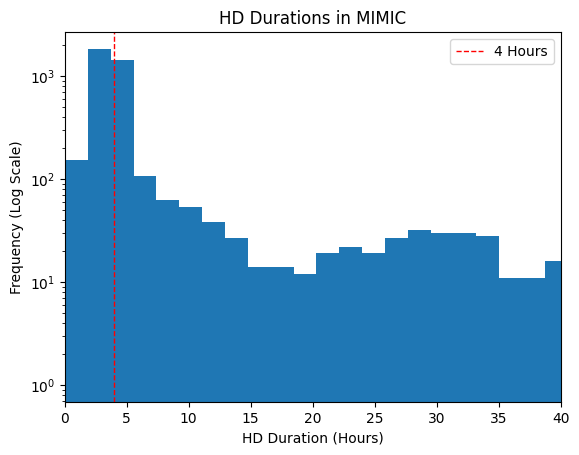

In [92]:
# --- EDA VIZ on HD DURATIONS
# show the distribution of the HD durations in hours
# sns.histplot(hd_events['value_hr'], bins=200)
plt.hist(hd_events["value_hr"], bins = 200)
plt.xlim((0,40))
plt.yscale("log")
plt.xlabel('HD Duration (Hours)')
plt.axvline(x=4, color='red', linestyle='--', linewidth=1, label='4 Hours')
plt.ylabel('Frequency (Log Scale)')
plt.title('HD Durations in MIMIC')
plt.legend()
plt.show()

In [177]:
def match_pe_and_ce(pe_df, ce_df, pe_mode: {"crrt", "ihd", "pd"} = "ihd", buffer_hours: int = 1):
    '''
    # TODO - RESUME
    '''
    pe_col_names_ = ['index', 'hadm_id', 'starttime', 'endtime', 'storetime', 'value_hr'] if pe_mode == "ihd" else pe_col_names
    
    joined = pd.merge(
        pe_df[pe_col_names_],
        ce_df[ce_col_names],
        how = "inner", on = "hadm_id", indicator = True
    )
    
    if pe_mode == "ihd":
        joined["o_rate"] = round(joined["valuenum"] / joined["value_hr"], 2)
    
    # "match" is True is charttime falls between start and end time
    joined["match"] = (joined["starttime"] - timedelta(hours = buffer_hours) <= joined["charttime"]) & (joined["charttime"] <= joined["endtime"] + timedelta(hours = buffer_hours))
    
    # find the match rate of PE (% PE that has at least one corresonding CE)
    # i.e. how many HD procedures has at least one charted val in between?
    pe_match_indices = joined.loc[joined["match"] == True, "index_x"].unique()
    pe_match_rate = len(pe_match_indices) / len(pe_df)
    print(f"{len(pe_match_indices)} ({pe_match_rate * 100:.1f}%) procedures have at least one corresponding chart events.")
    
    # how many charted val has at least one corresponding procedures?
    ce_match_indices = joined.loc[joined["match"] == True, "index_y"].unique()
    ce_match_rate = len(ce_match_indices) / len(ce_df)
    print(f"{len(ce_match_indices)} ({ce_match_rate * 100:.1f}%) chart events have at least one corresponding procedures.") 
    
    return joined.loc[joined["match"] == True,:]

hd_and_hdo = match_pe_and_ce(hd_events, hdo_events, "ihd", 0)
hd_and_hdo

1503 (34.5%) procedures have at least one corresponding chart events.
1591 (32.8%) chart events have at least one corresponding procedures.


index_x   hadm_id           starttime             endtime  \
0            1  20012928 2123-02-28 09:15:00 2123-02-28 15:33:00   
3            6  20050595 2202-12-01 16:56:00 2202-12-03 10:42:00   
4            6  20050595 2202-12-01 16:56:00 2202-12-03 10:42:00   
5           10  20070470 2158-01-24 18:20:00 2158-01-25 18:52:00   
12          11  20070470 2158-01-29 13:00:00 2158-01-29 17:00:00   
...        ...       ...                 ...                 ...   
15383     4352  29990494 2171-05-26 14:30:00 2171-05-26 18:15:00   
15390     4355  29992506 2201-08-29 07:30:00 2201-08-29 11:00:00   
15397     4357  29992506 2201-09-09 13:00:00 2201-09-09 15:53:00   
15401     4358  29992506 2201-09-11 12:06:00 2201-09-11 15:57:00   
15402     4359  29993312 2163-10-20 08:27:00 2163-10-20 11:23:00   

                   storetime_x  value_hr  index_y           charttime  \
0      2123-02-28 15:33:53.177      6.30        0 2123-02-28 12:55:00   
3       2202-12-03 10:42:37.03     41.77        4 2202-12-01 21:37:00   
4       2202-12-03 10:42:37.03     41.77        5 2202-12-02 13:00:00   
5          2158-01-25 18:59:00     24.53       11 2158-01-24 21:23:00   
12         2158-01-29 17:34:00      4.00       14 2158-01-29 17:00:00   
...                        ...       ...      ...                 ...   
15383      2171-05-26 18:25:00      3.75     4848 2171-05-26 18:00:00   
15390      2201-08-29 11:27:00      3.50     4850 2201-08-29 10:00:00   
15397      2201-09-09 16:27:00      2.88     4851 2201-09-09 15:50:00   
15401      2201-09-11 18:05:00      3.85     4852 2201-09-11 15:52:00   
15402      2163-10-20 11:41:00      2.93     4853 2163-10-20 11:23:00   

               storetime_y  valuenum valueuom _merge  o_rate  match  
0      2123-02-28 12:56:00    1200.0       mL   both  190.48   True  
3      2202-12-02 00:37:00    2000.0       mL   both   47.88   True  
4      2202-12-02 23:44:00    2000.0       mL   both   47.88   True  
5      2158-01-24 21:23:00    1000.0       mL   both   40.77   True  
12     2158-01-29 18:02:00    2000.0       mL   both  500.00   True  
...                    ...       ...      ...    ...     ...    ...  
15383  2171-05-26 18:27:00     500.0       mL   both  133.33   True  
15390  2201-08-29 10:20:00    1400.0       mL   both  400.00   True  
15397  2201-09-09 16:28:00     750.0       mL   both  260.42   True  
15401  2201-09-11 15:52:00    1400.0       mL   both  363.64   True  
15402  2163-10-20 11:06:00    1200.0       mL   both  409.56   True  

[1696 rows x 14 columns]

In [175]:
match_pe_and_ce(crrt_events, uf_events, "crrt")

4157 (97.8%) procedures have at least one corresponding chart events.
199426 (91.6%) chart events have at least one corresponding procedures.


_merge
both          1009184
left_only           0
right_only          0
dtype: int64

In [178]:
match_pe_and_ce(hd_events, uf_events, "ihd")

624 (14.3%) procedures have at least one corresponding chart events.
4211 (1.9%) chart events have at least one corresponding procedures.


index_x   hadm_id           starttime             endtime  \
4022         17  20079585 2145-12-03 22:18:00 2145-12-04 02:27:00   
4023         17  20079585 2145-12-03 22:18:00 2145-12-04 02:27:00   
4024         17  20079585 2145-12-03 22:18:00 2145-12-04 02:27:00   
4025         17  20079585 2145-12-03 22:18:00 2145-12-04 02:27:00   
4026         17  20079585 2145-12-03 22:18:00 2145-12-04 02:27:00   
...         ...       ...                 ...                 ...   
347956     4335  29918315 2177-01-10 17:59:00 2177-01-15 13:23:00   
347957     4335  29918315 2177-01-10 17:59:00 2177-01-15 13:23:00   
347958     4335  29918315 2177-01-10 17:59:00 2177-01-15 13:23:00   
348143     4347  29966638 2110-08-27 17:30:00 2110-08-27 19:45:00   
348194     4348  29966638 2110-08-29 09:45:00 2110-08-29 12:00:00   

                    storetime_x  value_hr  index_y           charttime  \
4022        2145-12-10 21:43:00      4.15     1255 2145-12-03 22:00:00   
4023        2145-12-10 21:43:00      4.15     1256 2145-12-03 23:00:00   
4024        2145-12-10 21:43:00      4.15     1257 2145-12-04 00:00:00   
4025        2145-12-10 21:43:00      4.15     1258 2145-12-04 01:00:00   
4026        2145-12-10 21:43:00      4.15     1259 2145-12-04 02:00:00   
...                         ...       ...      ...                 ...   
347956  2177-01-15 13:23:46.413    115.40   216723 2177-01-15 05:00:00   
347957  2177-01-15 13:23:46.413    115.40   216724 2177-01-15 06:00:00   
347958  2177-01-15 13:23:46.413    115.40   216725 2177-01-15 07:00:00   
348143      2110-08-27 19:27:00      2.25   217074 2110-08-27 19:26:00   
348194      2110-08-29 12:39:00      2.25   217076 2110-08-29 12:00:00   

                storetime_y  valuenum valueuom _merge   o_rate  match  
4022    2145-12-04 00:08:00      11.0       mL   both     2.65   True  
4023    2145-12-04 00:07:00     237.0       mL   both    57.11   True  
4024    2145-12-04 01:08:00     337.0       mL   both    81.20   True  
4025    2145-12-04 02:11:00     328.0       mL   both    79.04   True  
4026    2145-12-04 03:11:00     407.0       mL   both    98.07   True  
...                     ...       ...      ...    ...      ...    ...  
347956  2177-01-15 06:25:00     341.0       mL   both     2.95   True  
347957  2177-01-15 07:12:00     328.0       mL   both     2.84   True  
347958  2177-01-15 08:22:00     351.0       mL   both     3.04   True  
348143  2110-08-27 19:26:00    3000.0       mL   both  1333.33   True  
348194  2110-08-29 15:39:00    3000.0       mL   both  1333.33   True  

[4563 rows x 14 columns]

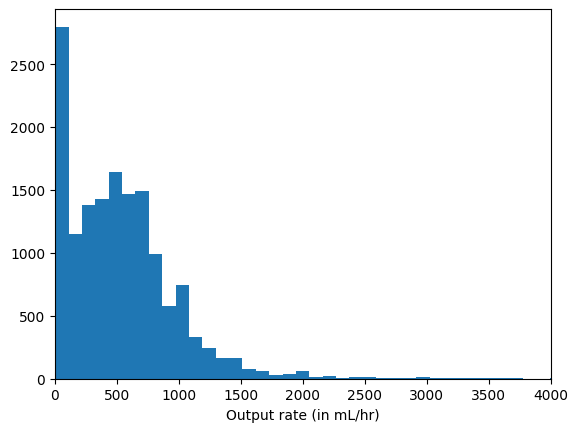

In [174]:
# plot the rate distribution of the 
plt.hist(hd_and_hdo["o_rate"], bins = 600)
plt.xlim(0,4000)
plt.xlabel("Output rate (in mL/hr)")
plt.show()

In [98]:
# check dups -- i.e if one chart event is captured by multiple different procedures
hdo_to_hd_dups = hd_and_hdo[hd_and_hdo.duplicated(subset=["index_y"], keep = False)] 
hdo_to_hd_dups

index_x   hadm_id           starttime             endtime  \
18          14  20079585 2145-11-22 17:30:00 2145-11-24 08:37:00   
22          15  20079585 2145-11-22 17:30:00 2145-11-24 08:44:00   
649        185  20518469 2169-02-06 08:00:00 2169-02-11 18:57:00   
659        186  20518469 2169-02-06 17:46:00 2169-02-11 19:00:00   
811        245  20668073 2127-10-03 09:05:00 2127-10-08 16:29:00   
...        ...       ...                 ...                 ...   
15252     4275  29742376 2123-03-18 12:00:00 2123-03-18 18:31:00   
15278     4294  29796943 2161-05-06 08:30:00 2161-05-06 12:30:00   
15280     4295  29796943 2161-05-06 09:00:00 2161-05-06 12:30:00   
15367     4338  29933107 2179-10-03 08:30:00 2179-10-04 18:28:00   
15368     4339  29933107 2179-10-03 08:35:00 2179-10-03 12:30:00   

                   storetime_x  value_hr  index_y           charttime  \
18         2145-11-24 08:50:00     39.12       16 2145-11-22 20:00:00   
22         2145-11-24 08:50:00     39.23       16 2145-11-22 20:00:00   
649        2169-02-11 21:10:00    130.95      217 2169-02-06 17:46:00   
659        2169-02-11 21:10:00    121.23      217 2169-02-06 17:46:00   
811     2127-10-08 16:29:15.33    127.40      277 2127-10-03 12:22:00   
...                        ...       ...      ...                 ...   
15252  2123-03-18 18:31:19.363      6.52     4760 2123-03-18 16:54:00   
15278      2161-05-06 17:34:00      4.00     4783 2161-05-06 12:15:00   
15280      2161-05-06 12:32:00      3.50     4783 2161-05-06 12:15:00   
15367  2179-10-04 18:28:05.437     33.97     4824 2179-10-03 12:00:00   
15368      2179-10-03 14:13:00      3.92     4824 2179-10-03 12:00:00   

               storetime_y  valuenum valueuom  
18     2145-11-23 04:45:00     800.0       mL  
22     2145-11-23 04:45:00     800.0       mL  
649    2169-02-06 17:46:00     476.0       mL  
659    2169-02-06 17:46:00     476.0       mL  
811    2127-10-03 12:22:00    2100.0       mL  
...                    ...       ...      ...  
15252  2123-03-18 16:54:00    1500.0       mL  
15278  2161-05-06 12:32:00    2000.0       mL  
15280  2161-05-06 12:32:00    2000.0       mL  
15367  2179-10-03 14:15:00    3000.0       mL  
15368  2179-10-03 14:15:00    3000.0       mL  

[198 rows x 11 columns]

In [29]:
# now, check for CE-PE "congruence"
hd_and_hdo_missed = hd_and_hdo.loc[
    (~hd_and_hdo["index_x"].isin(hd_and_hdo_inrange["index_x"])) & (~hd_and_hdo["index_y"].isin(hd_and_hdo_inrange["index_y"])),
    :
]
hd_and_hdo_missed

index_x   hadm_id           starttime             endtime  \
1            2  20021612 2162-05-07 13:10:00 2162-05-07 16:23:00   
2            3  20030303 2158-03-15 07:10:00 2158-03-15 10:10:00   
50          22  20089631 2175-04-08 11:45:00 2175-04-08 15:15:00   
52          22  20089631 2175-04-08 11:45:00 2175-04-08 15:15:00   
56          25  20099155 2177-07-20 18:52:00 2177-07-20 20:52:00   
...        ...       ...                 ...                 ...   
15376     4345  29955812 2140-04-06 08:52:00 2140-04-06 12:49:00   
15377     4347  29966638 2110-08-27 17:30:00 2110-08-27 19:45:00   
15378     4348  29966638 2110-08-29 09:45:00 2110-08-29 12:00:00   
15379     4349  29966638 2110-09-14 09:30:00 2110-09-14 19:05:00   
15386     4353  29990494 2171-05-27 09:00:00 2171-05-27 12:20:00   

               storetime_x  value valueuom_x  index_y           charttime  \
1      2162-05-07 17:07:00  193.0        min        1 2162-05-07 17:07:00   
2      2158-03-15 08:17:00    3.0       hour        3 2158-03-15 10:19:00   
50     2175-04-08 16:41:00  210.0        min       20 2175-04-04 13:25:00   
52     2175-04-08 16:41:00  210.0        min       22 2175-04-08 15:21:00   
56     2177-07-20 18:53:00    2.0       hour       26 2177-07-25 17:00:00   
...                    ...    ...        ...      ...                 ...   
15376  2140-04-06 16:09:00  237.0        min     4837 2140-04-06 13:09:00   
15377  2110-08-27 19:27:00  135.0        min     4839 2110-08-30 18:23:00   
15378  2110-08-29 12:39:00  135.0        min     4839 2110-08-30 18:23:00   
15379  2110-09-15 06:02:00  575.0        min     4839 2110-08-30 18:23:00   
15386  2171-05-27 12:26:00  200.0        min     4849 2171-05-27 13:30:00   

               storetime_y  valuenum valueuom_y  
1      2162-05-07 17:07:00    1800.0         mL  
2      2158-03-15 10:20:00    4000.0         mL  
50     2175-04-04 13:26:00    2000.0         mL  
52     2175-04-08 15:21:00    2500.0         mL  
56     2177-07-25 17:59:00    1400.0         mL  
...                    ...       ...        ...  
15376  2140-04-06 16:09:00     600.0         mL  
15377  2110-08-30 18:25:00    1500.0         mL  
15378  2110-08-30 18:25:00    1500.0         mL  
15379  2110-08-30 18:25:00    1500.0         mL  
15386  2171-05-27 13:30:00     500.0         mL  

[6077 rows x 12 columns]

In [168]:
# how many HD procedures has no charted val in between?
hd_wo_hdo = hd_events.loc[
    (~hd_events["index"].isin(hd_and_hdo["index_x"])),
    :
]
hd_wo_hdo_rate = len(hd_wo_hdo) / len(hd_events)
print(f"{len(hd_wo_hdo)} ({hd_wo_hdo_rate * 100:.1f}%) HD procedures have NO corresponding HDO chart events.")

640 (14.7%) HD procedures have NO corresponding HDO chart events.


In [179]:
# how many charted val has no corresponding procedures?
hdo_wo_hd = hdo_events.loc[
    (~hdo_events["index"].isin(hd_and_hdo["index_y"])),
    :
]
hdo_wo_hd_rate = len(hdo_wo_hd) / len(hdo_events)
print(f"{len(hdo_wo_hd)} ({hdo_wo_hd_rate * 100:.1f}%) HD output chart events have NO corresponding HD procedure.")

3263 (67.2%) HD output chart events have NO corresponding HD procedure.


### EDA of super long HD

In [129]:
'''
checked: 
- 37 - 22 UF CE
- 33, 63
- 7 no corresonding CE
'''
idx_eg = 63
find_ce_within_pe(hd_events, idx_eg, hdo_events)

index_x   hadm_id           starttime             endtime  \
0       63  20195118 2140-03-14 14:19:00 2140-03-15 14:18:00   

               storetime_x   value valueuom_x  index_y           charttime  \
0  2140-03-15 14:18:46.813  1439.0        min       67 2140-03-14 16:02:00   

           storetime_y  valuenum valueuom_y _merge  
0  2140-03-14 16:03:00    1800.0         mL   both

In [130]:
# find if this super long HD has other charted UF output -- there is
find_ce_within_pe(hd_events, idx_eg, uf_events, 1)

index_x   hadm_id           starttime             endtime  \
0       63  20195118 2140-03-14 14:19:00 2140-03-15 14:18:00   

               storetime_x   value valueuom_x  index_y charttime storetime_y  \
0  2140-03-15 14:18:46.813  1439.0        min      NaN       NaT         NaN   

   valuenum valueuom_y     _merge  
0       NaN        NaN  left_only

In [121]:
# find if this super long HD has other charted UF output -- there is
find_ce_within_pe(hd_events, idx_eg, hfr_events)

index_x   hadm_id           starttime             endtime  \
0        9  20068469 2131-11-19 09:22:00 2131-11-19 17:21:00   

              storetime_x  value valueuom_x  index_y charttime storetime_y  \
0  2131-11-19 17:21:36.83  479.0        min      NaN       NaT         NaN   

   valuenum valueuom_y     _merge  
0       NaN        NaN  left_only

In [122]:
find_ce_within_pe(hd_events, idx_eg, dr_events)

index_x   hadm_id           starttime             endtime  \
0        9  20068469 2131-11-19 09:22:00 2131-11-19 17:21:00   

              storetime_x  value valueuom_x  index_y charttime storetime_y  \
0  2131-11-19 17:21:36.83  479.0        min      NaN       NaT         NaN   

   valuenum valueuom_y     _merge  
0       NaN        NaN  left_only

In [133]:
# TODO: write the CE -> PE function

# see how many chart events does a super long HD cover
def find_pe_covering_ce(ce_df, ce_idx, pe_df, buffer_hours: int = 1):
    '''
    Find the procedure event that covers a chart event.
    '''
    ce_row = ce_df[ce_df["index"] == ce_idx]
    hadm_id = ce_row["hadm_id"].values[0]
    charttime = pd.to_datetime(ce_row["charttime"].values[0])
        
    pe_select = pe_df.loc[
        (pe_df["hadm_id"] == hadm_id) & 
        (pe_df["starttime"] <= charttime + timedelta(hours=buffer_hours)) &
        (charttime - timedelta(hours=buffer_hours) <= pe_df["endtime"])
    ]
    # return pe_select
    return pd.merge(
        pe_select[pe_col_names], ce_row[ce_col_names],
        how = "outer", on = "hadm_id", indicator = True
    )

find_pe_covering_ce(hdo_events, 46, hd_events)

index_x   hadm_id           starttime             endtime  \
0       37  20128314 2117-01-04 08:53:00 2117-01-09 16:58:00   

           storetime_x   value valueuom_x  index_y           charttime  \
0  2117-01-09 22:46:00  7685.0        min       46 2117-01-04 12:05:00   

           storetime_y  valuenum valueuom_y _merge  
0  2117-01-04 12:05:00       0.0         mL   both

### Viz

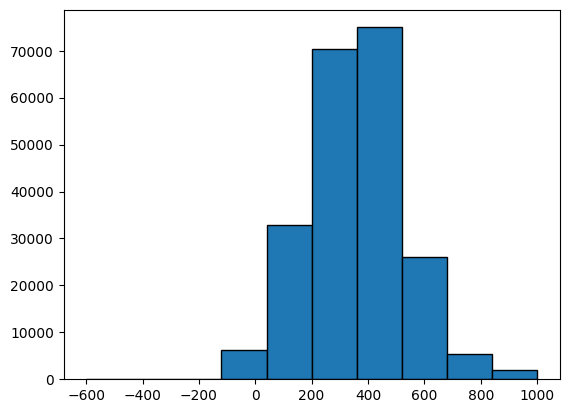

In [83]:
# UF output
import matplotlib.pyplot as plt
plt.hist(uf_events['valuenum'].clip(upper=1000), bins=10, edgecolor='black')
plt.show()

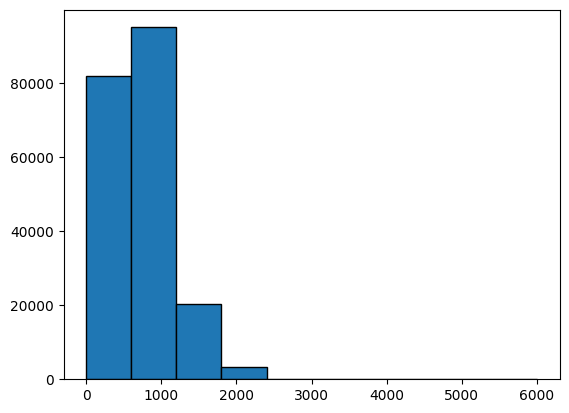

In [180]:
# DR input
plt.hist(dr_events['valuenum'].clip(upper=6000), bins=10, edgecolor='black')
plt.show()

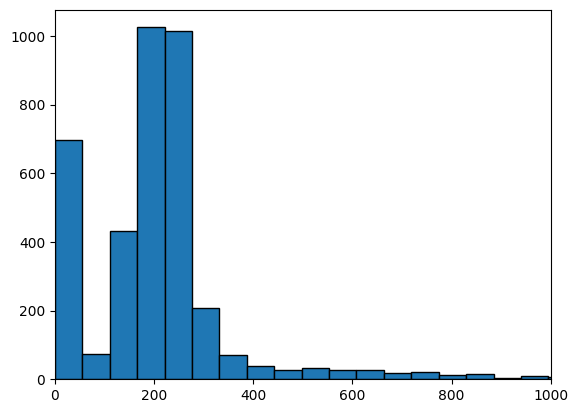

In [134]:
plt.hist(hd_events['value'], bins = 400, edgecolor='black')
plt.xlim(0,1000)
plt.show()